---
---
# READ ME / Introduction
---
---

This is the explainer notebook for the research paper **A Universe Connected: Insights from Star Wars Character Network Analysis**, and encompasses the steps of the analysis summarized in the paper.

The primary dataset is a data dump of all pages from the Star Wars Wiki, Wookieepedia. This dataset is preprocessed in the file ```download_preprocess_wookieepedia.py```.

The research purpose is analyzing the network of Star Wars characters and their Wookieepedia articles, how they connect via page links to eachother, how their attributes reveal interesting characteristics about the network and the star wars universe at-large, and what insights can be gathered from the contents of their articles, analyzed using various NLP methods.

To optimize the reading flow of this notebook, and given the large number of processing and analysis steps performed, as much code as possible has been aggregated into callable functions, and moved out into separate utility scripts, from which they can be imported. These files are categorized as:
- ```util_dataset_preprocess.py``` for various custom dataset processing functions
- ```util_network.py``` for various custom network processing and analysis functions
- ```util_nlp.py``` for various custom NLP processing and analysis functions


The notebook is divided into the following sections:
1. Dataset Preprocessing
2. Loading Dataset of Canon Articles and Characters
3. Building the Character Link Network (CLN)
4. Processing Specific Character Attributes
5. Analysis of Network Properties
6. Sentiment Analysis
7. Affiliation Analysis
8. Community Analysis

---
---
# Dataset Preprocessing
---
---

## Data Collection
The analysis began with a complete dataset dump from Wookieepedia's statistics page, containing 645,829 pages (1.84 GB) stored 7z format and unpacked into XML format. This raw dump included all types of pages from the wiki, including articles, categories, templates, images, user pages, forum discussions, and much more. The download page can be found here: https://starwars.fandom.com/wiki/Special:Statistics

The dataset dump was preprocessed in the file ```download_preprocess_wookieepedia.py```

## Content Processing
Each retained page underwent several processing steps:

1. **Initial Filtering** 
   - The first step involved filtering out non-relevant page types. Only three types of pages were retained:
     - Articles (main content pages)
     - Categories (used for article aggregation)
     - Templates (containing structured data like infoboxes, which can be used to classify the type of article)
   - All other page types, such as user pages, forum discussions, and image pages, were discarded based on Wookieepedia's namespace classifications, found here: https://starwars.fandom.com/wiki/Special:AllPages
2. **Text Extraction**
   - Raw text was extracted from the XML structure
   - Pages without meaningful text content were discarded
   - MediaWiki formatting was parsed using ```mwparserfromhell```to obtain clean, readable text
3. **Link Processing**
   - Internal links to other articles were extracted using the parser
   - Category links were separately identified and stored
   - External links were excluded from the analysis, only links to other articles were kept
4. **Template Analysis**
   - Special attention was given to two types of templates:
     - "Top" templates: Used to determine whether content belongs to Canon or Legends continuity. Criteria documentation can be found here: https://starwars.fandom.com/wiki/Template:Top
     - Infobox templates: Containing structured information about the article subject
   - Template parameters were extracted and stored in a structured format
5. **Continuity Classification**
   - Pages were flagged as either Canon, Legends or none of them based on their template "Top" information
6. **Infobox processing**
   - Infoboxes were identified by their template type (e.g., "Character", "Droid", "Planet", "Organization" and more), and used to classify the type of the article
   - Furthermore, all infobox attributes and their values were saved along the article, to be available for further processing and analysis

## Resulting Datasets
The preprocessing resulted in three distinct datasets:

1. **Complete Cleaned Dataset**
   - 322,218 pages (741.7 MB)
   - Includes all valid articles, categories, and templates
   - Stored in JSON format for easier access

2. **Canon Subset**
   - 69,272 pages (273.9 MB)
   - Contains only content from the current official Star Wars continuity, found by filtering pages without the Canon flag
   - Used for all subsequent analysis

3. **Legends Subset**
   - 115,030 pages (377.4 MB)
   - Contains content from the pre-Disney continuity, found by filtering pages without Legends flag
   - Archived for potential comparative analysis

## Analysis Scope
For the purpose of analyzing the current Star Wars universe, only the Canon subset was used in subsequent analysis. This decision ensures that all analyzed content reflects the current official Star Wars continuity and storytelling.

---
---
# Loading Dataset of Canon Articles and Characters
---
---

### Imports & Config Setup

The below cell contains library imports, as well as custom network, dataset and NLP processing & analysis functions from util files, and finally setup of NLP tools

In [1]:
import json
import networkx as nx
import numpy as np
import powerlaw
import random
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from community import community_louvain
from collections import Counter, defaultdict
from IPython.display import display, HTML
from util_network import extract_largest_directed_weakly_cc, plot_directed_hist_loglog_distribution, calculate_statistics, analyze_directed_network, print_network_analysis, analyze_affiliations, print_analysis_results
from util_dataset_preprocess import extract_link, extract_link_text, unique_attribute_values, most_common_n_attribute_values, find_character_with_attribute_value, replace_attribute_value, remove_attribute_value, remap_character_affiliations, print_mapping_statistics, update_graph_affiliations, top_n_attribute_counter
from util_nlp import load_labmt_wordlist, tokenize_and_lemmatize, calculate_term_dispersion, create_mega_df, display_df_properties


# Set the random seed for reproducibility
random_state = 42
random.seed(random_state)       # Set seed for random module
np.random.seed(random_state)    # Set seed for numpy module

pd.set_option('display.max_colwidth', None) # Key setting for multi-line cells


# Download the required NLTK resources
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Initialize a lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# Stop words for filtering
stop_words = set(nltk.corpus.stopwords.words('english'))

# Load LabMT wordlist for sentiment analysis
labmt_dict = load_labmt_wordlist("../lectures/Data_Set_S1.txt")


### Load Dataset

The preprocessed dataset of canon articles is now ready to be loaded, and the subset of characters to be retrieved.

In [2]:
# Load the (sub)dataset of Canon Star Wars pages
input_path = "/Users/max-peterschroder/Library/Mobile Documents/com~apple~CloudDocs/Master Study/1. Semester/02805 Social Graphs/socialgraphs2024/final_project/canon_cleaned_wookieepedia_data.json"

try:
    with open(input_path, "r", encoding="utf-8") as f:
        pages_data = json.load(f)
    print(f"Dataset loaded successfully with {len(pages_data)} pages.")
except Exception as e:
    print(f"Error loading JSON file: {e}")
    exit()

# Store all canon pages & their respective titles
all_canon_pages = [
    page for page in pages_data
    if page.get("Canon")
]
all_canon_pages_titles = {article["title"] for article in all_canon_pages}
print(f"Found {len(all_canon_pages)} Canon article pages.")

# Test to see if all canon pages are marked as canon
i = 0
for page in pages_data:
    if page.get('Canon') == False:
        i += 1
assert i == 0, "ERROR, not all canon pages are marked as canon."

# Store all canon character pages & their respective titles
character_pages = [
    page for page in all_canon_pages 
    if page.get("page_type") == "Animate"
    and not page["title"].startswith(("Template:", "Category:"))
]
character_pages_titles = {place["title"] for place in character_pages}
print(f"Of these, {len(character_pages)} are Character pages (including both organic and droid characters).")

# Clean character links to only include links to other canon articles
character_links = {}
for character in character_pages:
    character_name = character["title"]
    links = [link for link in character.get("links", []) if link in all_canon_pages_titles] # Filter links to only include links to other canon articles
    character_links[character_name] = links

Dataset loaded successfully with 69272 pages.
Found 69272 Canon article pages.
Of these, 12871 are Character pages (including both organic and droid characters).


The Network of (Canon) Star Wars Characters can now be built. Characters include both organic and droid characters. Confusingly, organic characters have type article type 'Character', whilst droid characters have article type ' Droid', even though they are also a character.

We define characters as both organics and droids in text, but in the code Character will sometimes only mean organic characters, given the way the types are defined. Each character type has a set of infobox attributes we processed previously, with many overlapping. They are:

Character (organic) infobox attributes: type, name, homeworld, birth, death, species, gender, pronouns, height, mass, hair, feathers, eyes, skin, cyber, families, parents, partners, siblings, children, affiliation, masters, apprentices  
Droid infobox attributes: type, name, homeworld, birth, death, creator, manufacturer, line, model, class, cost, length, width, height, mass, gender, pronouns, sensor, plating, armament, equipment, affiliation

For the coming analysis, we are mostly interested in attributes "affiliation", "homeworld", "species", "class" and "gender", some of which require further processing.

---
---
# Building the Character Link Network (CLN)
---
---

Now we are ready to build the network of Star Wars characters. The nodes are defined as the characters, whilst the edges are built from the outgoing links to other characters in each characters article, and will therefore be directed.

Whilst building the network, each characters attributes will be further processed, as they currently are saved as raw strings. The processing depends on the type of attribute, and can be divided into the following types:
- Non-link attributes: Are kept as they are
- Link attributes: The attribute values are replaced with any links to other canon articles they may contain (format: [[link]])
- Link text attributes: The attribute values are replaced with the text that accompanies any links to other canon articles they may contain (format: [[link|text]])

The list of attributes for each processing type are defined below:

In [3]:
non_link_attributes = ["page_type", "page_subtype", "type", "name", "birth", "death", "pronouns", "height", "mass", "feathers", "eyes", "skin", "cyber", "line", "cost", "length", "width"] # Keep as is for Strings, or combination of strings and links like 2.3 [[meter]]s, 112 [[kilogram]]s, etc
link_attributes = ["homeworld", "species", "families", "parents", "partners", "siblings", "children", "affiliation", "masters", "apprentices", "creator", "manufacturer", "model", "class", "armament", "equipment"] # Extract valid links to other articles
link_text_attributes = ["gender", "hair", "sensor", "plating"] # Links where the link text is more important than the actual link, [[Gender|Male]], [[Color|Brown]], etc

Now the network can be built according to the aforementioned description. First each character is added as a node, with its attributes being processed, and after that the directed edges are added from the characters links to other characters. As a final step, the network is redefined as the largest weakly connected component.

(Small note: the "gender" attribute of droids is also renamed to "programmed_gender" to distinguish their gender identity from organic characters. This will be beneficial when analysing gender distributions later)

In [4]:
# Initialize a directed graph for the character link network
G_cln = nx.DiGraph()

# Add a node for each character
for character in character_pages:
    character_name = character["title"]
    character_subtype = character["page_subtype"]

    # Collect relevant attributes for the node from the character's data
    character_attributes = {}

    # Add the page type and subtype to the attributes
    character_attributes["page_type"] = character["page_type"]
    character_attributes["page_subtype"] = character["page_subtype"]
    character_attributes["plain_text"] = character["plain_text"]

    # Iterate over the attributes and clean only the relevant ones
    for key, value in character.items():
        if key in non_link_attributes: # These attributes are kept as they are
            character_attributes[key] = value
        if key in link_attributes:  # These attributes are cleaned and filtered to only include links to canon pages
            character_attributes[key] = [extract_link(v) for v in value if extract_link(v) in all_canon_pages_titles]
        if key in link_text_attributes:  # These attributes are cleaned and filtered to only include links text if the link is to a canon page
            if character_subtype == 'Droid' and key == 'gender':
                key = f"programmed_{key}"# Droids can have a programmed gender, so to distinguish between the gender of an organic and inorganic character, we add the prefix "programmed_" to the key for droids. This will be useful for the analysis.
            character_attributes[key] = [extract_link_text(v) for v in value if extract_link(v) in all_canon_pages_titles and extract_link_text(v) is not None]
            

    # Add the node with its cleaned attributes
    G_cln.add_node(character_name, **character_attributes)

print(f"Initialized Nodes: Network has {G_cln.number_of_nodes()} nodes and {G_cln.number_of_edges()} edges")

# Add edges between characters
for character, links in character_links.items():
    for link in links:
        # Only add the edge if the link is a character page
        if link in character_pages_titles:
            G_cln.add_edge(character, link)
print(f"Added Edges: Network has {G_cln.number_of_nodes()} nodes and {G_cln.number_of_edges()} edges")

G_cln = extract_largest_directed_weakly_cc(G_cln)

num_organic_characters = sum([1 for n, d in G_cln.nodes(data=True) if d["page_subtype"] == "Character"])
num_droids = sum([1 for n, d in G_cln.nodes(data=True) if d["page_subtype"] == "Droid"])
num_characters = num_organic_characters + num_droids
print(f"\nTotal number of characters: {num_characters}")
print(f"- Number of organic characters: {num_organic_characters} ({num_organic_characters/num_characters*100:.2f}%)")
print(f"- Number of inorganic characters (droids): {num_droids} ({num_droids/num_characters*100:.2f}%)")

Initialized Nodes: Network has 12871 nodes and 0 edges
Added Edges: Network has 12871 nodes and 58821 edges

Network is not one large weakly connected component, extracting...
Network after extraction: 11194 nodes, 58119 edges

Total number of characters: 11194
- Number of organic characters: 10150 (90.67%)
- Number of inorganic characters (droids): 1044 (9.33%)


The Character Link Network (CLN) is now ready.  
The ratio of organic to droid characters is quite high, with about 90.7% of characters being organic vs only 9.3% being droids.

---
---
# Processing Specific Character Attributes
---
---

We mentioned that we were particularly interested in analyzing character attributes of type "affiliation", "homeworld", "species", "class" and "gender" (and now "programmed_gender" for droids as well).

However, three of these types, "affiliation", "gender" & "programmed_gender" require a final level of processing, which is performed in this section.

## Affiliation Attribute Processing & Analysis
The "affiliation" character (node) attribute covers organizations that characters are affiliated with. There are thousands of organizations spanning large factions (like The Empire, Jedi Order, etc) to much smaller and less significant organizations (like small gangs, battalions, etc). In order to be able to meaningfully analyze the shared affiliations between characters, we need to limit them to a list of only the most significant / important / well-known organizations in the SW universe. For that, we need to define a subset of important organizations. Luckily, Wookieepedia already sort of provides such a list.

On an article of page subtype "Character" or "Droid", which is what we define our nodes in our network as, there is a parameter "type", which determines the colour of their infobox. The available type colourlist (found here: https://starwars.fandom.com/wiki/Template:Character) largely corresponds to the most significant factions in the SW universe. Using my SW domain knowledge, the list was further optimized, removing non-canon or irrelevant entries, and renaming others to more appropiate names. We refer to this list of organizations as the set of primary affiliations (well-known factions).

In total, 15 unique primary affiliations were identified, including classics such as "Galactic Empire", "Jedi Order" and "Mandalorians".

From there, we then mapped each characters current affiliations to their equivalent primay affiliation (if applicable), using a set of separate mapping rules for each primary affiliation. These rules include exact matches (entire string), contains (substring), string_starts (starts with), word_prefix (word starts with), and categories (node categories), and are set based on a combination of my SW domain knowledge and careful inspection to make sure the current matching rules lead to correct primary affiliation mappings. Most characters are expected to already have their primary affiliations amongst their current ones, but this mapping is still done, in case some characters may be missing the parent primary affiliation but have one or more derivative affiliations stated.

For example, we have the Rebel Alliance, a well known faction in the Star Wars universe. In actuality, it is called the "Alliance to Restore the Republic" (including on wookieepedia). However, it is often shortened to the Rebel Alliance. Therefore we define the mapping rules as: If a characters current affiliation (not case-sensitive) is exactly "rebel alliance" or "alliance to restore the republic", it immedietly matches that affiliation to the primary affiliation "Alliance to Restore the Republic". Otherwise, it checks for instances (substrings) of "rebel alliance" in the current affiliation name, and likewise matches if found.

Below is the code for the exact mapping rules for primary affiliation "Alliance to Restore the Republic":
```
"Alliance to Restore the Republic": {
    "exact_matches": ["rebel alliance", "alliance to restore the republic"],
    "contains": ["rebel alliance"],
    "string_starts": [],
    "word_prefix": [],
},
```
All other primary affiliations each have their own defined mapping rules

The execution steps for this process are seen below.

First, we identify the number and types of affiliations before remapping.

In [5]:
unique_attribute_values(G_cln, "affiliation")


Number of unique 'affiliation' attribute values: 1948
Unique values of 'affiliation' attribute: {'Kintan Striders Gang', 'Erso family', "Losha Tarkon's cantina", 'Duro Interstellar Freight and Shipping', "Dex's Diner", 'Defense Hierarchy Council', 'Dark Squadron', 'One Oh Third Task Force', 'Reena University', "Jabba Desilijic Tiure's criminal empire", "Jas Emari's crew", 'Royal House of Naboo', 'Trade Federation fleet', 'Hidden Path', 'Red Key Raiders', 'Hynestian Royal Guard', "Taborr's gang", "Gorian Shard's gang", "Galen Erso's field team", 'Anst Wozo', 'Corellian Engineering Corporation', 'Elite Squad', '975th Battalion', 'Royal Imperial Academy', "Even Piell's fleet group", 'Megalox', 'Mist-Weaver', "Iasento's tribe", 'Harra', 'Incom Corporation', 'Children of the Watch', 'Kamino garrison', 'Arkanis Academy', 'South Sector Sinners', 'Unknown Regions Imperial remnant', 'Xonti Brothers', 'Aleena monarchy', 'New Republic Special Forces', 'Pau City Police', 'Titan Squadron', 'Projec

There are a whopping 1948 unique affiliations. However, we see that many are unnecessarily small / obscure / irrelevant, such as 'Council of Elders (Ewok)' or 'Krynbalt Kyr', whatever that means. We are only interested in the important star wars factions, and so we will remap all affiliations to their equivalent primary affiliation (if they can be mapped to one) using a set of predefined mapping rules.

In [6]:
# Get the mapping statistics
mapping_stats = remap_character_affiliations(G_cln)

# Print detailed statistics including remapping lists
print_mapping_statistics(mapping_stats)

# Update the graph's affiliation attributes to use the primary affiliations
original_affiliations_example = G_cln.nodes['Anakin Skywalker']['affiliation'] # Example of the original affiliations for Anakin Skywalker
update_graph_affiliations(G_cln, mapping_stats)
primary_affiliations_example = G_cln.nodes['Anakin Skywalker']['affiliation'] # Example of remapped primary affiliations for Anakin Skywalker


Affiliation Mapping Statistics
Total characters processed: 11194
Characters with affiliations: 7852
Successful mappings: 6944

Remapping Lists by Primary Affiliation:

Alliance to Restore the Republic
--------------------------------
Total characters: 880
Maps from:
- Alliance to Restore the Republic
- Black Squadron (Rebel Alliance)
- Blue Squadron (Rebel Alliance)
- Gold Squadron (Rebel Alliance)
- Gray Squadron (Rebel Alliance)
- Green Squadron (Rebel Alliance)
- Rebel Alliance Corps of Engineers
- Rebel Alliance Intelligence Service
- Rebel Alliance Navy
- Rebel Alliance Special Forces
- Rebel Alliance Starfighter Command
- Rebel Alliance Starfighter Corps
- Red Squadron (Rebel Alliance)
- Signal Intelligence (Rebel Alliance)
- Yellow Squadron (Rebel Alliance)

Bounty Hunter
-------------
Total characters: 38
Maps from:
- Bounty Hunters Guild Social Club
- Bounty Hunters' Guild
- Sugi's bounty hunters
- Unidentified bounty hunter (Western Dune Sea)

Chiss Ascendancy
--------------

Original affiliations have now been remapped to their respective primary affiliations (if possible). The above print details the number of characters within each primary affiliation, as well as all the original affiliations which were remapped to each primary affiliation. This was repeatedly inspected during development to optimize the remapping rules, ensuring that the original affiliations being remapped are in fact a part of the respective primary affiliations.

The first primary affiliation printed is 'Alliance to Restore the Republic', with 880 characters now being affiliated with it. 15 original affiliations were remapped to this primary affiliation, most of which included the substring 'Rebel Alliance'.

Using my Star Wars domain knowledge, I can confirm that the final remappings for the primary affiliations make sense.

We then re-inspect the number and types of unique affiliations in the network.

In [7]:
unique_attribute_values(G_cln, "affiliation")


Number of unique 'affiliation' attribute values: 15
Unique values of 'affiliation' attribute: {'Nightsisters', 'Alliance to Restore the Republic', 'First Order', 'Crime Syndicates and Cartels', 'Nihil', 'Jedi Order', 'Galactic Empire', 'New Republic', 'Confederacy of Independent Systems', 'Resistance', 'Chiss Ascendancy', 'Mandalorians', 'Galactic Republic', 'Bounty Hunter', 'Sith Order'}


This confirms that the remapping was succesful, as only the wanted primary affiliations exist now.

To further test the results, we check the node data for Anakin Skywalker, and compared his affiliations before and after the remapping. Note that the article for Anakin Skywalker both includes his life as a Jedi knight, and his life as the iconic Darth Vader, and so will include affiliations for both.

In [8]:
print("Example of affiliation remapping for Anakin Skywalker (includes life as Darth Vader):")
print(f"Number of original affiliations for Anakin Skywalker: {len(original_affiliations_example)}")
print(f"Original affiliations for Anakin Skywalker: {original_affiliations_example}")
print(f"Number of primary affiliations for Anakin Skywalker (after remapping): {len(primary_affiliations_example)}")
print(f"Primary affiliations for Anakin Skywalker (after remapping): {primary_affiliations_example}")

Example of affiliation remapping for Anakin Skywalker (includes life as Darth Vader):
Number of original affiliations for Anakin Skywalker: 17
Original affiliations for Anakin Skywalker: ['Jedi Order', 'Jedi High Council', 'Galactic Republic', '7th Sky Corps', '302nd Battalion', '501st Legion', 'Office of the Chancellor', 'Sith', 'Galactic Empire', 'Imperial High Command', 'Imperial Ruling Council', 'Joint Chiefs of the Imperial Military', 'Death Squadron', "Darth Vader's secret forces", "Vader's crew", 'Droid uprising', 'Schism Imperial']
Number of primary affiliations for Anakin Skywalker (after remapping): 4
Primary affiliations for Anakin Skywalker (after remapping): ['Galactic Republic', 'Jedi Order', 'Galactic Empire', 'Sith Order']


Previously, Anakin had 17 affiliations, many of them being largely unnecessary for the coming analysis.  
His 4 primary affiliations after remapping paint a much clearer picture. We have 'Jedi Order' and 'Galactic Republic' from his time as a Jedi during the Clone Wars, and 'Galactic Empire' and 'Sith Order' from his time as Darth Vader in the Empire.

We can now analyze the distribution of faction allegiances in the network. We inspect the top 10 primary affiliations by character count.

In [9]:
most_common_n_attribute_values(G_cln, 'affiliation', top_n=10)


Most common 'affiliation' values (Top 10):
  'Galactic Empire': 1652 characters
  'Galactic Republic': 987 characters
  'Jedi Order': 708 characters
  'Alliance to Restore the Republic': 706 characters
  'New Republic': 340 characters
  'Crime Syndicates and Cartels': 319 characters
  'Confederacy of Independent Systems': 282 characters
  'Resistance': 264 characters
  'First Order': 246 characters
  'Nihil': 220 characters


From the top 10 primary affiliations, we can gather the following insights:

### Original Trilogy Era
- The Galactic Empire (1,652) significantly outnumbers its opposition, the Alliance to Restore the Republic (706)
- This disparity likeluy reflects the Empire's vast bureaucratic and military structure, compared to the more focused Rebel Alliance
- The Empire's larger representation also likelu stems from its presence across multiple eras of Star Wars media

### Prequel Trilogy Era
- Galactic Republic (987) vastly outnumbers the Confederacy of Independent Systems (282)
- This disparity can be attributed to:
  - Extensive coverage of Republic clone troopers as individual characters, particurlarly from The Clone Wars show
  - Focus on Jedi characters within the Republic
  - Separatists often portrayed through unnamed droids or a smaller cast of recurring characters, often villains

### Sequel Trilogy Era
- Resistance (264) and First Order (246) show nearly equal representation
- This balance suggests more evenly distributed character development between opposing factions in newer Star Wars content

### Jedi vs Sith Representation
- Jedi Order (708) has significant representation
- Sith Order notably absent from top 10 affiliations
- This aligns with Star Wars lore where:
  - Jedi Order was a large institution during its prime
  - Sith followed the "Rule of Two" limiting their numbers

Important note:  
Characters can have multiple primary affiliations, particularly during transitional periods (e.g., Galactic Republic to Empire). This overlap affects the total character count and reflects the complex political landscape of the Star Wars universe.

## Gender Attribute Processing

Organic characters have a 'gender' attribute, whilst droids have an equivalent 'programmed_gender' attribute. The issue becomes that the gender types written in the wiki articles are not consistent, as capitalization and misspellings lead to multiple different possible values for each gender. The gender values are aggregated to standard types, allowing for the gender distributions to be analyzed.

### Organic Characters

First we inspect the unique 'gender' values that exist to see if there is overlap (due to misspellings or lack of standardization), and then view the top 10 'gender' values (for reference before processing)

In [10]:
unique_attribute_values(G_cln, 'gender') # Inspect unique 'gender' values to check for overlap
most_common_n_attribute_values(G_cln, 'gender', top_n=10) # Inspect most common 'gender' values with counts, used as reference for cleaning


Number of unique 'gender' attribute values: 7
Unique values of 'gender' attribute: {'female', 'Female', 'Males', 'Male', 'Hermaphrodite', 'Non-binary', 'Masculine programming'}

Most common 'gender' values (Only 7 unique values):
  'Male': 4484 characters
  'Female': 2299 characters
  'Non-binary': 32 characters
  'female': 2 characters
  'Hermaphrodite': 1 characters
  'Masculine programming': 1 characters
  'Males': 1 characters


There are some instances of 'gender' value 'Female' being written as 'female' and 'Male' being written as 'Males', which should be standardized.

Only one character has 'gender' value 'Hermaphrodite', and so warants further investigation.

Furthermore, one character has 'gender' value 'Masculine programming', despite it being a droid-exclusive gender identity, which also warants further investigation.

In [11]:
# Some female characters (standard is 'Female') mistakenly have their gender as 'female', so we standardize it
replace_attribute_value(G_cln, attribute='gender', old_value='female', new_value='Female')
  
# Some male characters (standard is 'Male') mistankenly have their gender as 'Males', so we standardize it
replace_attribute_value(G_cln, attribute='gender', old_value='Males', new_value='Male')

find_character_with_attribute_value(G_cln, 'gender', 'Hermaphrodite') # Investigate the single character with the 'Hermaphrodite' gender
find_character_with_attribute_value(G_cln, 'gender', 'Masculine programming') # Investigate the character with the 'Masculine programming' gender, which should be exclusive to droids


Replaced 2 instances of 'female' with 'Female' in 'gender'

Replaced 1 instances of 'Males' with 'Male' in 'gender'

Characters with 'gender' value 'Hermaphrodite': ['Unidentified Dianoga']

Characters with 'gender' value 'Masculine programming': ['Unidentified serving droid']


The character with 'gender' value 'Hermaphrodite' is 'Unidentified Dianoga', which is a type of non-sentient creature (and therefore not a character), so its gender value is removed.

The character with 'gender' value 'Masculine programming' is a droid, but is classified as an organic character. Inspecting the wikitext source of the Wookieepedia article of the character reveals that the characters infobox is mistakenly of type "Character" instead of "Droid" (link: https://starwars.fandom.com/wiki/Unidentified_serving_droid?veaction=editsource). This is not that problematic for the following network analysis, so its gender value is simply removed.

Furthermore, empty 'gender' values are assigned as 'Unknown'.

In [12]:
remove_attribute_value(G_cln, attribute='gender', remove_value='Hermaphrodite')
remove_attribute_value(G_cln, attribute='gender', remove_value='Masculine programming')

replace_attribute_value(G_cln, attribute='gender', old_value=None, new_value="Unknown") # Replace empty 'gender' values with 'Unknown'

most_common_n_attribute_values(G_cln, 'gender')


Removed 1 instances of 'Hermaphrodite' from 'gender'

Removed 1 instances of 'Masculine programming' from 'gender'

Replaced 3332 instances of 'None' with 'Unknown' in 'gender'

Most common 'gender' values (Only 4 unique values):
  'Male': 4485 characters
  'Unknown': 3332 characters
  'Female': 2301 characters
  'Non-binary': 32 characters


The organic character 'gender' attribute preprocessing is now complete. About 1/3 of characters do not have a specified gender.

We see that there are three major genders in the SW universe: Male, Female and Non-binary, with almost 2/3rds of gendered characters being Male, 1/3 being female and < 0.5% being Non-binary. The Star Wars franchise has primarily been marketed to boys since its inception, given its focus on sci-fi elements, conflict and war (and arguably only recently has started appealing to women as well after the acquisition of the franchise by Disney), so it would make sense that most characters are male to reflect that.

### Droids

Now, the same gender processing is performed for droids, using their equivalent attribute "programmed_gender".

We start off by inspecting the unique "programmed_gender" values to check for misspellings or lack of standardization.

In [13]:
unique_attribute_values(G_cln, 'programmed_gender') # Inspect unique 'programmed_gender' values to check for overlap
most_common_n_attribute_values(G_cln, 'programmed_gender', top_n=10) # Inspect most common 'programmed_gender' values with counts, used as reference for cleaning


Number of unique 'programmed_gender' attribute values: 20
Unique values of 'programmed_gender' attribute: {'masculine programming', 'Female programming', 'Masculine', 'Masculine Programing', 'Non-binary', 'Masculine Programming', 'Feminine', 'Feminine-programmed', 'programming', 'Feminine programing', 'Masculine-programmed', 'Male programming', 'Femenine programming', 'Feminine Programming', 'Masculine programmed', 'Feminine programming', 'Male', 'Masculine programing', 'Masculine programming', 'Female-programming'}

Most common 'programmed_gender' values (Top 10):
  'Masculine programming': 241 characters
  'Feminine programming': 75 characters
  'Masculine programing': 7 characters
  'Masculine': 6 characters
  'Masculine Programming': 3 characters
  'Feminine': 3 characters
  'programming': 2 characters
  'Feminine programing': 1 characters
  'Masculine-programmed': 1 characters
  'Feminine Programming': 1 characters


We see that the the programmed genders of droids correspond to the primary gender types found for organic characters (Male, Female & Non-binary). However, there is a lack of consistency between the Male and Female 'gender' values, as multiple exist for each type (due to misspellings and lack of standardization across the wiki articles). We select one spelling as the standard value, and then change all other equivalent values into it.

"Feminine programming" and "Masculine programming" become the standardized values for their respective genders, and 'Non-binary' will be replaced with 'Programed non-binary' for consistency.

Furthermore, two instances of simply 'programming' are present. As the programmed gender cannot be deduced from it, both instances are removed.

Finally, droids without a 'programmed_gender' value will have it assigned as "None/Unknown".

In [14]:
all_unique_feminine_programming_values = ['Feminine programming', 'Feminine', 'Female-programming', 'Femenine programming', 'Feminine-programmed', 'Female programming', 'Feminine programing', 'Feminine Programming'] # All possible values seen for feminine droid programming
new_feminine_programming_value = 'Feminine programming' # Standardized value

all_unique_masculine_programming_values = ['masculine programming', 'Masculine programmed', 'Masculine', 'Male programming', 'Masculine programming', 'Male', 'Masculine programing', 'Masculine Programming', 'Masculine Programing', 'Masculine-programmed'] # All possible values seen for masculine droid programming
new_masculine_programming_value = 'Masculine programming' # Standardized value

print(f"\nReplacing all {len(all_unique_feminine_programming_values)} different types of female programming gender values with standardized value '{new_feminine_programming_value}'")
for old_value in all_unique_feminine_programming_values: # For each old female programming value, replace it with the new standardized value
    replace_attribute_value(G_cln, attribute='programmed_gender', old_value=old_value, new_value=new_feminine_programming_value, add_newline=False)

print(f"\nReplacing all {len(all_unique_masculine_programming_values)} different types of masculine programming gender values with standardized value '{new_masculine_programming_value}'")
for old_value in all_unique_masculine_programming_values: # For each old male programming value, replace it with the new standardized value
    replace_attribute_value(G_cln, attribute='programmed_gender', old_value=old_value, new_value=new_masculine_programming_value, add_newline=False)

# Replace 'Non-binary' with 'Programed non-binary' to distinguish between gender of organic and droid characters
replace_attribute_value(G_cln, attribute='programmed_gender', old_value='Non-binary', new_value='Programed non-binary')

# Remove instances of 'programming', as it is not clear what type of gendered programming it refers to.
remove_attribute_value(G_cln, attribute='programmed_gender', remove_value='programming')

# Replace empty 'programmed_gender' values with 'None/Unknown'
replace_attribute_value(G_cln, attribute='programmed_gender', old_value=None, new_value="None/Unknown")


Replacing all 8 different types of female programming gender values with standardized value 'Feminine programming'
Replaced 3 instances of 'Feminine' with 'Feminine programming' in 'programmed_gender'
Replaced 1 instances of 'Female-programming' with 'Feminine programming' in 'programmed_gender'
Replaced 1 instances of 'Femenine programming' with 'Feminine programming' in 'programmed_gender'
Replaced 1 instances of 'Feminine-programmed' with 'Feminine programming' in 'programmed_gender'
Replaced 1 instances of 'Female programming' with 'Feminine programming' in 'programmed_gender'
Replaced 1 instances of 'Feminine programing' with 'Feminine programming' in 'programmed_gender'
Replaced 1 instances of 'Feminine Programming' with 'Feminine programming' in 'programmed_gender'

Replacing all 10 different types of masculine programming gender values with standardized value 'Masculine programming'
Replaced 1 instances of 'masculine programming' with 'Masculine programming' in 'programmed_gen

In [15]:
most_common_n_attribute_values(G_cln, 'programmed_gender', top_n=10)


Most common 'programmed_gender' values (Only 4 unique values):
  'None/Unknown': 696 characters
  'Masculine programming': 263 characters
  'Feminine programming': 84 characters
  'Programed non-binary': 1 characters


The inorganic character (droid) 'programmed_gender' attribute preprocessing is now complete. About 2/3 of droids either do not have a programmed gender identity, or it is not specified. 

Of the droids with programmed gender identities, about 3/4ths have masculine programming, and the rest have feminine programming, with only one having non-binary programming. This male/female distribution is even more skewed than for the organic characters, however it is worth noting that droid characters only make up about 10% of all characters. Still, this difference is more difficult to explain than for the organic characters. It could be that combat and utility droids are often seen as "male" roles, of which there are many in the Star Wars universe, and so therefore have that assigned gender identity.

With that, the network and attribute processing is now complete, and the network is ready for analysis.

---
---
# Analysis of Network Properties
---
---

In this section, the Character Link Network (CLN) and its network properties are analysed, in an effort to determine its central characters and their roles in connecting the network.

We start of by inspecting the node attributes of Anakin Skywalker to see if they look as expected.

In [16]:
# Inspect the node data for Anakin Skywalker to see if the cleaning worked
anakin_node_data = G_cln.nodes['Anakin Skywalker'].copy()
del anakin_node_data['plain_text'] # Remove the plain text from the node data for better readability
print(anakin_node_data)

{'page_type': 'Animate', 'page_subtype': 'Character', 'type': ['Jedi'], 'name': ['Anakin SkywalkerDarth Vader'], 'homeworld': ['Tatooine'], 'birth': ['41 BBY'], 'death': ['4 ABY'], 'species': ['Human'], 'gender': ['Male'], 'pronouns': ['He/him'], 'height': ['meter'], 'mass': ['kilogram'], 'hair': ['Blond'], 'feathers': [], 'eyes': ['Blue, later yellow'], 'skin': ['Light, later pale'], 'cyber': ['Cybernetics|Cybernetic', 'Mechno-arm|prosthetic arms', 'Life support|life-support'], 'families': ['Skywalker family', 'Naberrie family'], 'parents': ['Shmi Skywalker Lars', 'Cliegg Lars'], 'partners': ['Padmé Amidala'], 'siblings': ['Owen Lars', 'Sola Naberrie'], 'children': ['Luke Skywalker', 'Leia Skywalker Organa Solo'], 'affiliation': ['Galactic Republic', 'Jedi Order', 'Galactic Empire', 'Sith Order'], 'masters': ['Qui-Gon Jinn', 'Obi-Wan Kenobi', 'Darth Sidious', 'Yoda'], 'apprentices': ['Ahsoka Tano', 'Inquisitorius', 'Corvax descendant']}


Node attributes look as we would like. We can confirm this by observing the values for well-known information, such as his homeworld being Tatooine, his partner being Padmé Amidala, and his children being Luke Skywalker and Leia Organa, and him having (amongst others) Obi-Wan Kenobi as his master.

It is noteworthy that a small fraction of the attributes are not processed correctly. Attributes with combination of important string information and links only have their links saved, such as "height"=['meter'], although it likely originally was something like "height"="1.82 [['meter']]". This is due to the way the preprocessing only keeps the raw string if no links are present, and otherwise keeps the links (but preserves the link text if it exists). However, this case is only relevant to metric attributes that won't be relevant to this project, such as "height" and "mass", so for now it doesn't matter.

We move on to investigating the degree distribution of the network. Given that it is a directed network, both the in- and out-degree distributions are analyzed.

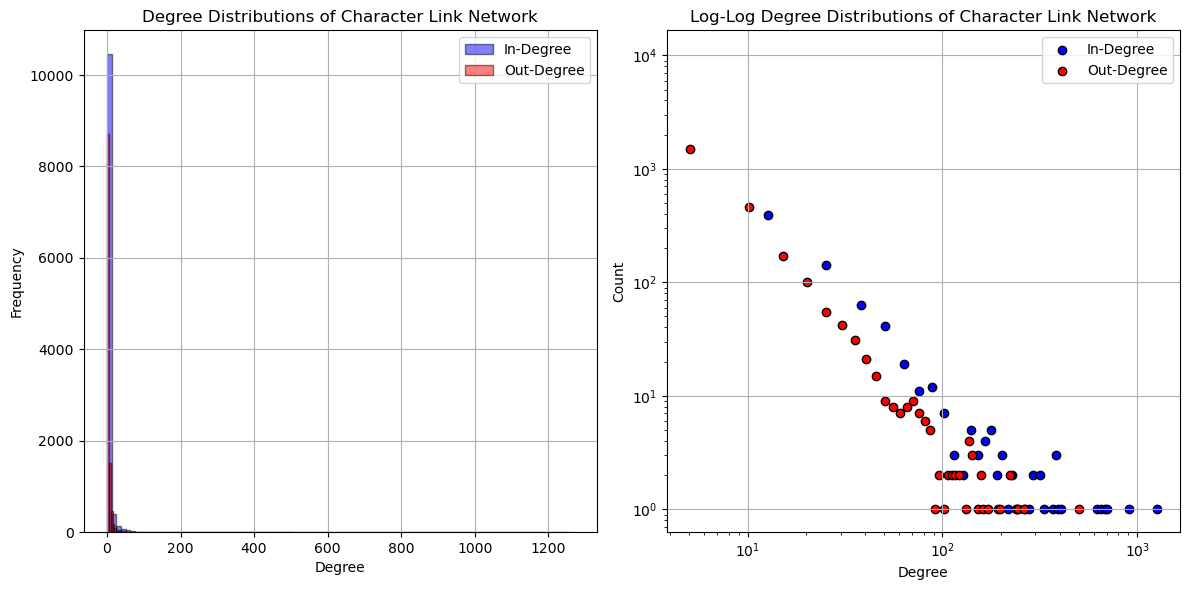

In [17]:
# Calculate in-degree and out-degree distributions
k_in = dict(G_cln.in_degree())
k_out = dict(G_cln.out_degree())
k_in_values = np.array(list(k_in.values()))
k_out_values = np.array(list(k_out.values()))

# Plot the in-degree and out-degree distributions
plot_directed_hist_loglog_distribution(k_in_values, k_out_values, num_bins=100, title_network_name='Character Link Network')

Looking at the Log-Log degree distribution plot, we see that there are a small number of characters who are connected to many other characters, whilst the majority of characters have only a few outgoing or incoming links. It looks as if the in- and out-degree distributions approximately seem to follow powerlaw in a similar pattern, suggesting that the network is scale-free.

The fact that in-degree tends to be higher could imply that most characters are referenced or discussed more often than they link to others. This could reflect:
- Main characters (e.g., Luke Skywalker, Darth Vader) may be the focal points of many other characters’ articles, leading to a high in-degree. These characters might be referenced in the context of many other characters' stories, or appear in many discussions, leading to many incoming links.
- Less central or minor characters may have less incoming links because they are not as widely referenced in other characters’ articles, even if they have many outgoing links.

We can further calculate statistics for the in- and out-degree distributions.

In [18]:
calculate_statistics(k_in_values, "In-Degree")
calculate_statistics(k_out_values, "Out-Degree")

Statistics for In-Degree:
Mean: 5.19, Median: 1, Mode: 0, Min: 0, Max: 1269
Statistics for Out-Degree:
Mean: 5.19, Median: 3, Mode: 1, Min: 0, Max: 506


Looking at the statistics for in- and out-degree distributions separately, we see that they both have the same mean, which makes sense given that an edge always leads to one outgoing and one incoming degree in the network. The Median is three times higher for outgoing than incoming degrees, which is necessary if a few characters are expected to have significantly higher in-degrees than out-degrees. The minimum for both is 0, which is to be expected since the network is only weakly connected. The maximum for in-degrees is 1269, which is significantly higher than the maximum for out-degrees at 506.

Given the approximate power-law behavior of both distributions, we calculate their respective power law exponents.

In [19]:
gamma_in = powerlaw.Fit(k_in_values).alpha
gamma_out = powerlaw.Fit(k_out_values).alpha

print("In-Degree power law exponent: ", gamma_in)
print("Out-Degree power law exponent: ", gamma_out)
# 

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-Degree power law exponent:  2.3548739441526925
Out-Degree power law exponent:  2.6875138159512906


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


For both exponents, 2 < gamma < 3, meaning the networks in- and out-degrees are both in the Ultra-Small world regime. Here, the presence of hubs radically reduces the average path length, but the network is not completely dominated by a single hub.

Now, we perform an in-depth analysis of the assortativity and various centrality measures in the network to identify key network properties and central characters.

In [20]:
# Calculate metrics (will take some time)
metrics = analyze_directed_network(G_cln)

Analyzing directed graph with 11194 nodes and 58119 edges...
Computing betweenness centrality (this may take a while)...Completed betweenness centrality in 228.5s
Computing PageRank...Completed PageRank in 0.0s
Computing HITS scores...Completed HITS in 0.1s
Computing eigenvector centrality...
Analysis completed in 282.9 seconds


In [21]:
# Print network analysis
print_network_analysis(metrics)


NETWORK OVERVIEW
Number of Nodes: 11,194
Network Density: 0.0005
Reciprocity: 0.4884

ASSORTATIVITY PATTERNS
in_in_assortativity: -0.0743
in_out_assortativity: -0.0654
out_in_assortativity: -0.0853
out_out_assortativity: -0.0727

CENTRALITY MEASURES

Incoming Connections:
  Average: 0.0005
  Maximum: 0.1134 (Node Anakin Skywalker)
  Minimum: 0.0000

Outgoing Connections:
  Average: 0.0005
  Maximum: 0.0452 (Node Anakin Skywalker)
  Minimum: 0.0000

Path Centrality:
  Average: 0.0002
  Maximum: 0.1007 (Node Anakin Skywalker)
  Minimum: 0.0000

PageRank:
  Average: 0.0001
  Maximum: 0.0158 (Node Anakin Skywalker)
  Minimum: 0.0000

Hub Score:
  Average: 0.0001
  Maximum: 0.0037 (Node Anakin Skywalker)
  Minimum: -0.0000

Authority Score:
  Average: 0.0001
  Maximum: 0.0215 (Node Anakin Skywalker)
  Minimum: -0.0000

Eigenvector Centrality:
  Average: 0.0022
  Maximum: 0.3100 (Node Anakin Skywalker)
  Minimum: 0.0000

Incoming Closeness:
  Average: 0.1294
  Maximum: 0.2167 (Node Anakin S

Looking at the results, we can gather the following insights.

The network has very low density (0.0005), meaning only about 0.05% of possible connections between characters actually exist, although this is common for social networks. However, the reciprocity is quite high (0.4884), telling us that when there is a link between characters, about 49% of the time they link to each other. This makes sense for a wiki network - if character A is important enough to mention on character B's page, there's a good chance B is also important enough to mention on A's page.

The slightly negative assortativity coefficients (all around -0.07 to -0.08) is not that significant (different from 0), but it tells us that characters with many connections tend to (slightly more) link to characters with fewer connections, and vice versa. This suggests a hierarchical structure where major characters connect to many minor characters, but minor characters don't necessarily connect to each other.

Anakin Skywalker emerges as the central figure in the network across every single measure, which makes perfect sense given his pivotal role in the Star Wars saga. A relevant factor is that his article also comprises his Darth Vader persona, which is equally if not more important in the Star Wars universe.
- His high incoming connections (0.1134) show that about 11% of all characters in the network have links to his page - he's the most referenced character.
- His high betweenness centrality (0.1007) indicates he's a crucial bridge between different parts of the network. This reflects his unique position connecting the prequel era (as Anakin) and original trilogy (as Vader) characters.

The closeness centrality scores are particularly interesting:
- His outgoing closeness (0.4058) shows he can reach other characters through very short paths, meaning his page contains links to many important characters across all eras
- His incoming closeness (0.2167) shows others can also reach him easily, reflecting his central role in the saga

Looking at other characters, we see different patterns:
- Darth Sidious consistently ranks second or third across most metrics, reflecting his importance as the overarching antagonist of the entire saga
- Luke, Leia, and Han form a tight cluster in many metrics, showing their importance as the core trio of the original trilogy
- Obi-Wan Kenobi and Ahsoka Tano have particularly high eigenvector centrality scores, suggesting they're well-connected to other important characters
- Yoda ranks high in betweenness centrality but lower in other measures, suggesting he serves as an important connector between different groups of characters

The presence of R2-D2 in the top hub scores suggests that droid characters may serve as important connectors in the wiki network, linking characters across different time periods and storylines.

Given Anakin Skywalkers dominance in the network, the question becomes what happens if he is removed. Therefore a subnetwork without him is created, from which the above analysis is re-done.

In [22]:
# Remove Anakin Skywalker from the network
G_removed_as = G_cln.copy()
G_removed_as.remove_node("Anakin Skywalker")

# Extract the largest weakly connected component of the subnetwork
G_removed_as = extract_largest_directed_weakly_cc(G_removed_as)


Network is not one large weakly connected component, extracting...
Network after extraction: 11118 nodes, 56288 edges


In [23]:
# Calculate metrics (will take some time)
metrics_removed_as = analyze_directed_network(G_removed_as)

Analyzing directed graph with 11118 nodes and 56288 edges...
Computing betweenness centrality (this may take a while)...Completed betweenness centrality in 203.8s
Computing PageRank...Completed PageRank in 0.0s
Computing HITS scores...Completed HITS in 0.0s
Computing eigenvector centrality...
Analysis completed in 256.1 seconds


In [24]:
# Print network analysis
print_network_analysis(metrics_removed_as)


NETWORK OVERVIEW
Number of Nodes: 11,118
Network Density: 0.0005
Reciprocity: 0.4877

ASSORTATIVITY PATTERNS
in_in_assortativity: -0.0645
in_out_assortativity: -0.0511
out_in_assortativity: -0.0788
out_out_assortativity: -0.0588

CENTRALITY MEASURES

Incoming Connections:
  Average: 0.0005
  Maximum: 0.0811 (Node Darth Sidious)
  Minimum: 0.0000

Outgoing Connections:
  Average: 0.0005
  Maximum: 0.0238 (Node Leia Skywalker Organa Solo)
  Minimum: 0.0000

Path Centrality:
  Average: 0.0002
  Maximum: 0.0730 (Node Yoda)
  Minimum: 0.0000

PageRank:
  Average: 0.0001
  Maximum: 0.0122 (Node Darth Sidious)
  Minimum: 0.0000

Hub Score:
  Average: 0.0001
  Maximum: 0.0030 (Node Obi-Wan Kenobi)
  Minimum: -0.0000

Authority Score:
  Average: 0.0001
  Maximum: 0.0160 (Node Darth Sidious)
  Minimum: -0.0000

Eigenvector Centrality:
  Average: 0.0022
  Maximum: 0.2663 (Node Darth Sidious)
  Minimum: 0.0000

Incoming Closeness:
  Average: 0.1261
  Maximum: 0.2040 (Node Luke Skywalker)
  Minimu

The overall network structure remains remarkably stable after removing Anakin Skywalker. The network density (0.0005) and reciprocity (about 0.49) stay almost identical, suggesting that Anakin's connections, while numerous, weren't fundamentally altering the network's basic characteristics. This stability indicates that the Star Wars wiki network has a robust structure that doesn't depend solely on its most central character.

The assortativity coefficients remain negative but become slightly less pronounced (moving from around -0.07/-0.08 to -0.06/-0.07). This subtle shift suggests that Anakin was contributing somewhat to the hierarchical nature of the network, possibly through his many connections to minor characters across different eras of the saga.

When Anakin is removed, we see interesting shifts in how different characters take over various aspects of his central role:
1. Darth Sidious emerges as the primary successor in most metrics, taking over as the most central character in terms of:
   - Incoming connections (0.0811, down from Anakin's 0.1134)
   - PageRank (0.0122, down from 0.0158)
   - Authority score (0.0160, down from 0.0215)
   - Eigenvector centrality (0.2663, down from 0.3100)
   - Outgoing closeness (0.4022, similar to Anakin's 0.4058)

2. However, other characters step up in specific areas:
   - Leia takes the lead in outgoing connections (0.0238, much lower than Anakin's 0.0452)
   - Yoda becomes the most important bridge character (path centrality of 0.0730, down from Anakin's 0.1007)
   - Luke takes the lead in incoming closeness (0.2040, slightly lower than Anakin's 0.2167)
   - Obi-Wan Kenobi becomes the top hub (0.0030, down from Anakin's 0.0037)

This redistribution of centrality measures tells us something important about both the network and the Star Wars saga: while Anakin/Vader was uniquely positioned to connect all eras and aspects of Star Wars, his removal reveals a more distributed leadership structure where different characters excel in different types of connections and roles.

The analysis reveals a stable core group of characters who maintain their importance even without Anakin:
- Darth Sidious retains his position as a major antagonist and connector
- The original trilogy trio (Luke, Leia, and Han) maintain strong positions across metrics
- Obi-Wan and Ahsoka remain important connectors, particularly in terms of eigenvector centrality
- Yoda's role as a connector between different parts of the network becomes even more pronounced

One of the most telling aspects is how the maximum values for various centrality measures drop after removing Anakin. The most dramatic drops are in:
- Incoming connections (from 0.1134 to 0.0811)
- Path centrality (from 0.1007 to 0.0730)
- Outgoing connections (from 0.0452 to 0.0238)

These reductions show that no single character can fully replace Anakin's unique position in connecting different parts of the Star Wars universe, but the network adapts by distributing his various roles among several key characters.

This analysis reveals that while Anakin Skywalker/Darth Vader was indeed the most central character in the Star Wars universe, his removal doesn't fundamentally destabilize the network. Instead, it reveals a robust underlying structure where multiple characters share the burden of connecting the vast Star Wars narrative universe.

---
---
# Sentiment Analysis
---
---

A somewhat neutral sentiment distribution is expected accross a Wiki's articles, given its role as a neutral presentation of information about a category of topics, where articles are often written in as objective language as possible. Given the prevalence of emotionally charged themes and topics such as war, good VS evil, politics and more, the question becomes if that is reflected in the contents of the character articles. For this reason, a character sentiment analysis is perfomed.

First, each characters plain text is tokenized and lemmatized (including removing stop words, modal_verbs, and common function words), before calculating the term frequencies (TF). Words with a frequency count less than 5 are disregarded.  
TF normalization can be enabled, however this leads to issues with later TF-IDF calculations, as the floating point values become small enough that the significant digits do not differ between many words.  
Finally, the sentiment score for each character are calculated from the TF using term sentiment scores from the LabMT sentiment wordlist dataset. To avoid bias from characters with very few sentiment tokens, sentiment scores for characters with less than 10 sentiment tokens are dropped.

In [25]:
# Set text normalization and filtering parameters
normalize_tf = False # Normalize term frequencies to term frequency ratios, replaces normal tf_count
filter_words_below_count = 5 # Filter out words that appear less than this amount of times
filter_sentiment_below_count = 10 # Filter out sentiment scores for characters with less than this amount of sentiment tokens

# Initialize dictionaries to store the tokenized and lemmatized text, term frequencies, term frequency ratios, and sentiment scores for each character
character_tokens = {}
character_tf = {}
character_sentiments = {}

# Create a set of all character names and subnames
character_names = set()
for character, data in G_cln.nodes(data=True):
    character_names.add(character.lower())
    character_subnames = character.lower().split()

    for subname in character_subnames:
        if subname in ["unidentified", "mother", "father", "parent", "child", "sibling", "partner", "master", "apprentice", "droid"]:
            continue
        character_names.add(subname.lower())

# Create an extended set of stop words
extended_stop_words = set(stop_words)  # Start with your existing stop words

# Add modal verbs and common auxiliary verbs
modal_verbs = {
    "would", "could", "should", "might", "may", "must", "will", "shall",
    "can", "cannot", "can't", "won't", "wouldn't", "couldn't", "shouldn't"
}
extended_stop_words.update(modal_verbs)

# Add other common function words that might not be in stop words
common_function_words = {
    "become", "became", "becoming",
    "make", "made", "making",
    "take", "took", "taken", "taking",
    "get", "got", "getting", "gotten",
    "seem", "seemed", "seeming",
    "appear", "appeared", "appearing"
}

extended_stop_words.update(common_function_words)

# Add other common words that might not be in stop words
extra_words = {"category"}

extended_stop_words.update(extra_words)


for character, data in G_cln.nodes(data=True):
    # Tokenize and lemmatize the plain text
    tokens = tokenize_and_lemmatize(data.get('plain_text', ''), lemmatizer, extended_stop_words)
    
    # Filter out names
    tokens = [token for token in tokens if token.lower() not in character_names]

    # Count term frequencies
    tf_count = Counter(tokens)

    # Filter out words that appear less than 5 times
    tf_count = Counter({word: count for word, count in tf_count.items() if count >= filter_words_below_count})

    # Normalize term frequencies if the toggle is set
    if normalize_tf:
        # Total number of terms in the character
        total_terms = sum(tf_count.values())

        # Normalize term frequencies (TF) to term frequency ratios (TFR), done to avoid bias towards longer texts
        tf_count = {word: count / total_terms for word, count in tf_count.items()}

        # Sort the term frequency ratios
        tf_count = dict(sorted(tf_count.items(), key=lambda item: item[1], reverse=True))

    # Filter out tokens from the TF-count if they do not appear in the LabMT wordlist
    sentiment_tokens = [token for token in tf_count.keys() if token in labmt_dict]
    
    # Filter out the corresponding counts
    sentiment_counts = [tf_count[token] for token in tf_count.keys() if token in labmt_dict]

    # Retrieve sentiment values for tokens in the text if they are in the LabMT wordlist
    sentiment_scores = [labmt_dict[token] for token in sentiment_tokens]

    if len(sentiment_tokens) < filter_sentiment_below_count: # If there are less than this amount of sentiment tokens, set the sentiment to None. This is to avoid bias from characters with very few sentiment tokens.
        # print(character, len(set(tokens)), len(sentiment_tokens), sentiment_tokens)
        sentiment_text = None
    else: # Else return the sentiment of the text
        sentiment_text = sum([sentiment_scores[i] * sentiment_counts[i] for i in range(len(sentiment_scores))])/sum(sentiment_counts)

    # Store the tokenized text, term frequencies, term frequency ratios, and sentiment scores for the character
    character_tokens[character] = tokens
    character_tf[character] = tf_count
    character_sentiments[character] = sentiment_text

We perform a quick check to see if the tokenization, TF and sentiment calculations worked by inspecting Anakin Skywalker once again.

In [26]:
character = 'Anakin Skywalker'
print(len(character_tokens[character]))
print(G_cln.nodes[character]['plain_text'][:400])
print(str(character_tokens[character])[:400])
print(str(character_tf[character])[:400])
print(character_sentiments[character])

38410
Anakin Skywalker was a legendary Force-sensitive human male who was a Jedi Knight of the Galactic Republic and the prophesied Chosen One of the Jedi Order, destined to bring balance to the Force. Also known as "Ani" during his childhood, Skywalker earned the moniker "Hero With No Fear" from his accomplishments in the Clone Wars. His alter ego, Darth Vader, the Dark Lord of the Sith, was created wh
['legendary', 'prophesied', 'chosen', 'destined', 'bring', 'balance', 'also', 'known', 'ani', 'childhood', 'earned', 'moniker', 'hero', 'fear', 'accomplishment', 'war', 'alter', 'ego', 'vader', 'created', 'turned', 'side', 'pledging', 'allegiance', 'end', 'era', 'vergence', 'born', 'desert', 'planet', 'outer', 'territory', 'bby', 'slave', 'conceived', 'child', 'without', 'father', 'blood', 'contai
Counter({'vader': 2522, 'told': 286, 'war': 257, 'master': 245, 'however': 230, 'droid': 199, 'also': 167, 'back': 157, 'used': 152, 'asked': 144, 'mission': 132, 'found': 118, 'way': 117, 'at

By comparing Anakin Skywalkers plain text with the tokens, we see that the text has been properly tokenized.  
The TF count looks as expected, with some of the most common words unsurprisingly being "vader", "war" and "master".  
Anakin Skywalkers sentiment score is at a very neutral 5.25, which could make sense given his very long article content size (39820 tokens).

Now, its time for analysis of the entire distribution of sentiment scores across the network.

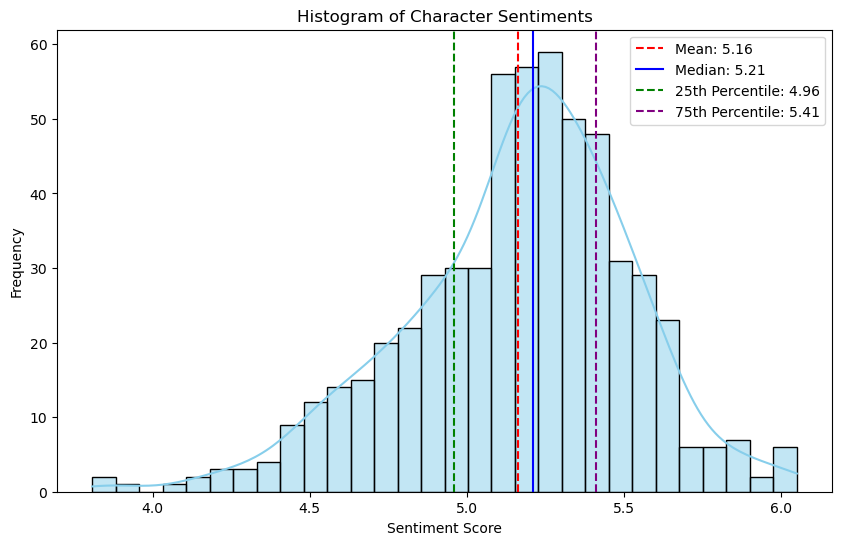

Summary Statistics:
count    577.000000
mean       5.162201
std        0.360689
min        3.807963
25%        4.957565
50%        5.209177
75%        5.410150
max        6.049231
Name: sentiment, dtype: float64

Variance of Sentiment: 0.1301


In [27]:
# Retrieve sentiments and create dataframe
sentiment_scores = character_sentiments.values()
df = pd.DataFrame(sentiment_scores, columns=["sentiment"])

# Calculate summary statistics
summary_stats = df["sentiment"].describe(percentiles=[0.25, 0.5, 0.75])
variance_sentiment = df["sentiment"].var()

# Retrieve the summary statistics
mean_sentiment = summary_stats['mean']
median_sentiment = summary_stats['50%']
percentile_25 = summary_stats['25%']
percentile_75 = summary_stats['75%']

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df["sentiment"], bins=30, kde=True, color="skyblue", edgecolor="black")

# Add vertical lines for mean, median, 25th and 75th percentiles
plt.axvline(mean_sentiment, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_sentiment:.2f}')
plt.axvline(median_sentiment, color='blue', linestyle='-', linewidth=1.5, label=f'Median: {median_sentiment:.2f}')
plt.axvline(percentile_25, color='green', linestyle='--', linewidth=1.5, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='--', linewidth=1.5, label=f'75th Percentile: {percentile_75:.2f}')

plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Histogram of Character Sentiments")
plt.legend()
plt.show()

print("Summary Statistics:")
print(summary_stats)
print("\nVariance of Sentiment:", round(variance_sentiment, 4))

Only 633 characters have sentiment scores, which is a very small amount compared to the total of 11194 characters in the network. Keep in mind that this number, and the overall sentiment score distribution, is very sensitive to the TF and sentiment token size filtering done in the previous step. Less strict filtering will lead to more bias from less frequent terms and characters with very little page content.

Also, before we analyse the sentiment distribution, it is worth noting that the term sentiment scores from the LabMT wordlist could be very different from the sentiment that words may carry inside of the star wars universe. For example, the word "dark" gets additional meaning in the Star Wars universe when used in the context "dark side", which is a (usually) very evil aspect of the force adopted by villains. Or the word "force", which in Star Wars is a whole concept on its own, and in the real-world is used in an entirely different context.

Therefore, the results are not expected to be entirely accurate.  
From the sentiment score distribution, we gather that the scores are largely normally distributed accross the mean of 5.19, which is a very neutral sentiment score (the range is from 1-10). Combined with the small variance of only 0.1175, this indicates that character sentiments accross the entire network are very neutral, proving that despite the many emotionally-charged subjects being common in Star Wars, the sentiment distribution still looks as you would expect from a Wiki. There are some significant outliers, like the minimum being quite low at 3.57. However, if this character is further investigated, you will see that the length of their article contents is quite small, and so their low sentiment score is likely biased from that.

Now that we have the TF for each character, we can calculate IDF for all terms in the network for each term, and combine them to get the TF-IDF scores for each character

In [28]:
# First, let's count document frequency (DF) for each term
# This tells us in how many character descriptions each term appears
document_frequency = defaultdict(int)
for character, tf_counts in character_tf.items():
    # For each character, increment DF for each unique term they have
    for term in tf_counts.keys():
        document_frequency[term] += 1

# Calculate the total number of documents (characters) in our network
total_documents = len(character_tf)

# Calculate IDF scores for all terms in the network
# We use log base 2 as it's common in text analysis
global_idf_scores = {}
for term, doc_freq in document_frequency.items():
    global_idf_scores[term] = np.log2(total_documents / doc_freq)

# Now calculate TF-IDF scores for each character
character_tf_idf = {}
for character, term_freqs in character_tf.items(): 
    tf_idf_scores = {}
    for term, norm_freq in term_freqs.items():
        # TF-IDF is the product of TF and IDF
        tf_idf_scores[term] = norm_freq * global_idf_scores[term]
    character_tf_idf[character] = tf_idf_scores

# Create a network-wide summary of term importance
global_tf_idf = {}
for term in document_frequency.keys():
    # Calculate average TF-IDF score for each term across all characters
    term_scores = [char_tfidf[term] 
                    for char_tfidf in character_tf_idf.values() 
                    if term in char_tfidf]
    global_tf_idf[term] = sum(term_scores) / len(term_scores)

Now we can find the top 5 TF counts and TF-IDF scores accross the entire network

In [29]:
# Aggregate all term frequencies across the network
global_tf = Counter()

for tf_count in character_tf.values():
    global_tf.update(tf_count)

# Get the top 5 terms by count
top_5_terms = global_tf.most_common(5)

# Sort terms by importance and get the top 5
top_5_tf_idf = sorted(global_tf_idf.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 terms across the network:")
for term, count in top_5_terms:
    print(f"{term}: {count}")

print("\nTop 5 important terms across the network (by average TF-IDF):")
for term, score in top_5_tf_idf:
    print(f"{term}: {score}")

Top 5 terms across the network:
war: 32074
empire: 10878
vader: 10724
droid: 9121
thrawn: 6844

Top 5 important terms across the network (by average TF-IDF):
thrass: 1014.9201063007564
pao: 887.7289101381131
russo: 753.2245298141565
kiro: 739.774091781761
miree: 666.0984347331673


The top 5 terms by count make sense. "war" is by far the most prevalent word, which is not surprising given it is literally in the name of the franchise, which is known for being a galaxy constantly at war. "empire" and "vader" also make sense, given both of their prevalences in the overall story of star wars, and also given the prevalence of Anakin Skywalker / Darth Vader in the network. "droid" is the next most popular word, reflecting their important role in the universe. And the final top 5 term is "thrawn", a popular villain originally from the Legends continuity, who was brought into the Canon continuity in season 3 of the Star Wars Rebels show (release date: September 24, 2016), and has later been included in many other Star Wars media. The fact that he in such an overall 'short' timeframe has gained such significance in the stories of all the characters in the universe shows he has become a very important character.

The top 5 most important terms appear to all be names, none of which I recognize. Star Wars is filled with wacky & wierd names for all kinds of characters and things, given its a sci-fi / fantasy universe, which are difficult to detect and sort out given that they often differ from naming structures that are prevalent in the real world.

---
---
# Affiliation Analysis
---
---

Given how important the factions in the Star Wars universe are, it warrants an analysis of the faction affiliations of the characters in the network. Recall that each character can have multiple affiliations, which does complicate the analysis slightly.

We start off by determining the number of co-occurances of two or more affiliations, which reveals patterns in how characters switch factions and allegiances over time.

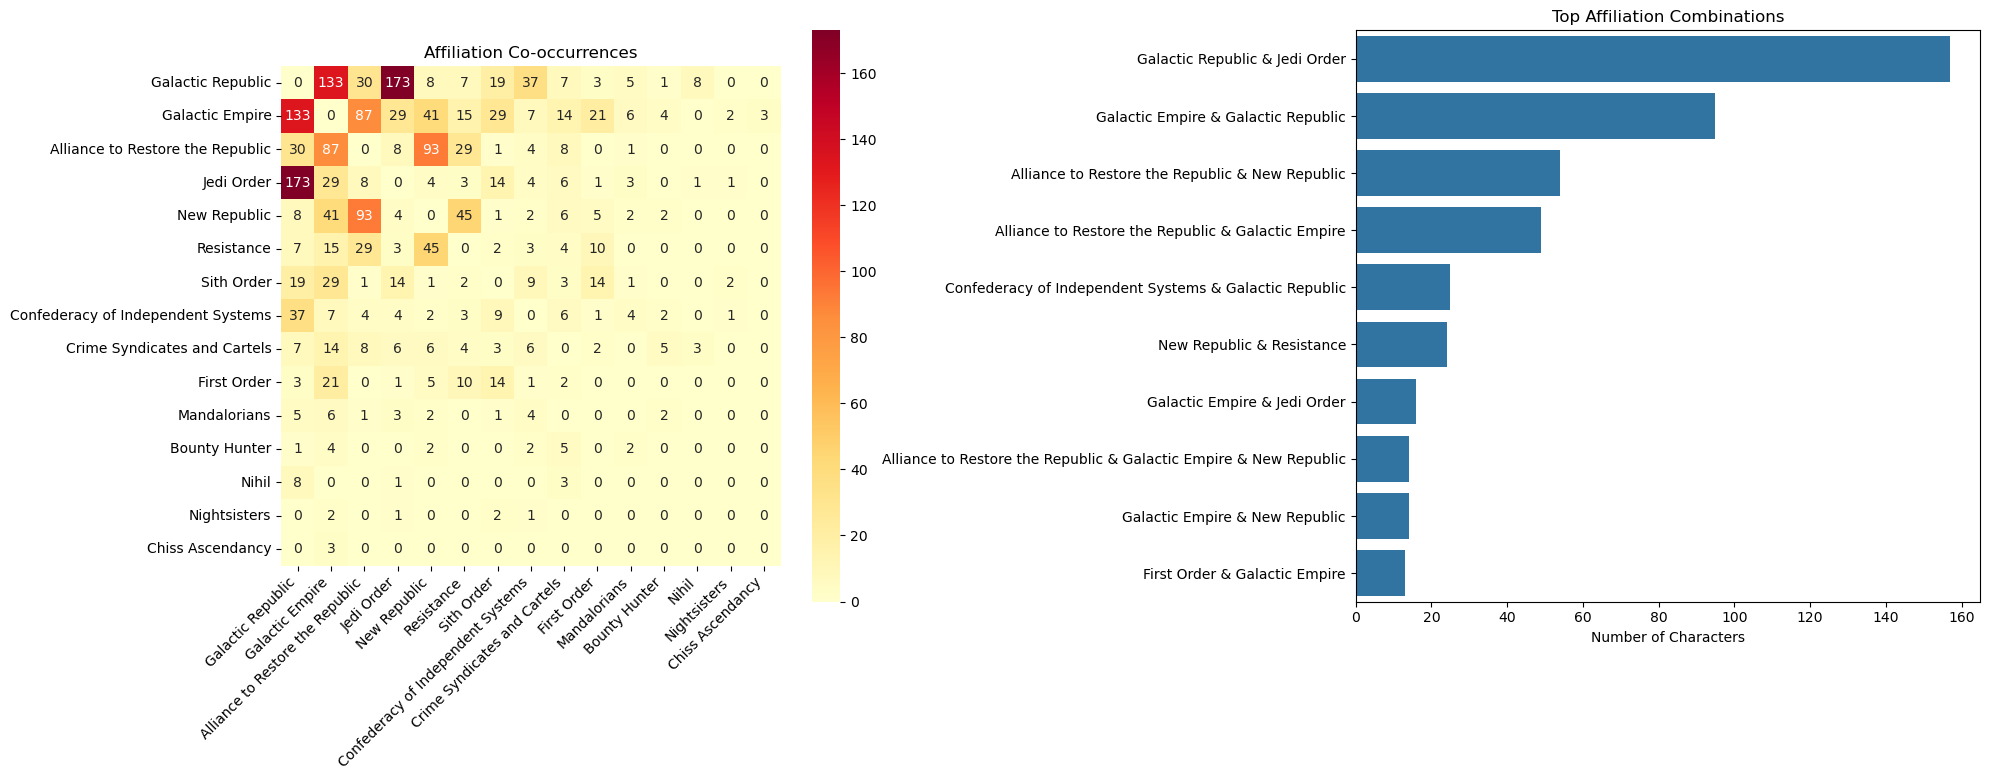


Top Individual Affiliation Pairs:
--------------------------------------------------
'Galactic Republic' & 'Jedi Order': 173 characters
'Galactic Republic' & 'Galactic Empire': 133 characters
'Alliance to Restore the Republic' & 'New Republic': 93 characters
'Galactic Empire' & 'Alliance to Restore the Republic': 87 characters
'New Republic' & 'Resistance': 45 characters
'Galactic Empire' & 'New Republic': 41 characters
'Galactic Republic' & 'Confederacy of Independent Systems': 37 characters
'Galactic Republic' & 'Alliance to Restore the Republic': 30 characters
'Galactic Empire' & 'Jedi Order': 29 characters
'Galactic Empire' & 'Sith Order': 29 characters

Top Complete Affiliation Combinations:
--------------------------------------------------
Galactic Republic & Jedi Order: 157 characters
Galactic Empire & Galactic Republic: 95 characters
Alliance to Restore the Republic & New Republic: 54 characters
Alliance to Restore the Republic & Galactic Empire: 49 characters
Confederacy of 

In [30]:
# Run the analysis
results = analyze_affiliations(G_cln)

# Display the visualization
plt.show()

# Print the detailed results
print_analysis_results(results)

Based on the co-affiliation results, we can extract the following insights.

**Most Significant Affiliation Overlaps**

1. **Jedi-Republic Connection** (173/157 characters)
   - Largest overlap reflects the deep integration of Jedi Order within the Galactic Republic
   - The slight difference between individual pairs and complete combinations suggests some Jedi had additional affiliations

2. **Republic-Empire Transition** (133/95 characters)
   - Significant number of characters served both governments
   - Shows the institutional transition from Republic to Empire
   - Difference between pairs and complete combinations indicates many had additional loyalties

3. **Rebel Alliance-New Republic Evolution** (93/54 characters)
   - Natural progression as Rebellion leaders became New Republic officials
   - Smaller complete combination number suggests many developed other affiliations

4. **Empire-Rebellion Defectors** (87/49 characters)
   - Significant number of Imperial defectors to the Rebellion
   - Important narrative theme in Star Wars (e.g., characters like Wedge Antilles)

5. **New Republic-Resistance Connection** (45/24 characters)
   - Shows continuity between eras

6. **Jedi-Empire Connection** (29/16 characters)
   - A not insignificant number of Jedi became affiliated with the Empire, indicating how many jedi were corrupted and became agents of the Empire during the fall of the Jedi Order.

**Notable Patterns**

1. **Institutional Transitions**
   - Clear chains of loyalty changes: Republic → Empire → New Republic → Resistance
   - Each transition shows declining numbers, reflecting narrative focus and time periods

2. **Cross-Faction Movement**
   - Significant number of characters with opposing affiliations
   - Reflects the complex political landscape and personal journeys

3. **Multiple Loyalties**
   - Difference between pair counts and complete combinations shows many characters had 3+ affiliations
   - Indicates complex character arcs and shifting allegiances

These affiliation co-occurences effectively captures the dynamic nature of political allegiances in the Star Wars universe, particularly during major governmental transitions and conflicts.

Now we analyze the characters among the entire network & individual factions by building a table with values accross 3 key areas:
- Affiliation network properties
- Affiliation demographic properties
- Affiliation term & sentiment properties

The table is constructed and analyzed across these key areas below.

In [31]:
affiliation_counts = Counter()
for _, node_data in G_cln.nodes(data=True):
    if 'affiliation' in node_data:
        affiliation_counts.update(node_data['affiliation'])
sorted_affiliation_counts = sorted(affiliation_counts.items(), key=lambda x: x[1], reverse=True)
all_affiliation_values = [affiliation for affiliation, count in sorted_affiliation_counts]

attributes = ['homeworld', 'species', 'class', 'gender', 'programmed_gender']
top_n_characters = 5
top_n_attribute = 5
top_n_tf = 5
top_n_tf_idf = 5
df_affiliations = create_mega_df(G_cln, attributes, all_affiliation_values, document_frequency, character_tf, character_tf_idf, character_sentiments, top_n_characters, top_n_attribute, top_n_tf, top_n_tf_idf)

# display(HTML(df_affiliations.to_html(escape=False)))

We start off by inspecting the results for only the complete network.

In [32]:
display_df_properties(df_affiliations, inspect_largest_n_columns=None, transpose=True)

,Size,Of these: Organics,Of these: Droids,Internal Density,Conductance,Average Clustering,Top 5 TF Counts,Top 5 TF-IDF Scores,Sentiment Sample Size (Characters),(Weighted) Average Sentiment,Sentiment Variance,Top 5 In-Degree,Top 5 Out-Degree,Top 5 homeworld,Top 5 species,Top 5 class,gender Distribution,programmed_gender Distribution
Entire Network,11194 (100.0%),10150 (90.7%),1044 (9.3%),0.000464,NaN,0.4857,war (32074.0)empire (10878.0)vader (10724.0)droid (9121.0)thrawn (6844.0),thrass (1014.9)pao (887.7)russo (753.2)kiro (739.8)miree (666.1),577,5.2870,0.1299,Anakin Skywalker (1269)Darth Sidious (903)Han Solo (701)Obi-Wan Kenobi (692)Leia Skywalker Organa Solo (659),Anakin Skywalker (506)Leia Skywalker Organa Solo (266)Obi-Wan Kenobi (245)Luke Skywalker (238)Ahsoka Tano (227),Kamino (2.8%)Tatooine (0.8%)Corellia (0.8%)Coruscant (0.8%)Naboo (0.7%),Human (36.4%)Twi'lek (2.1%)Rodian (1.4%)Chiss (1.2%)Trandoshan (0.8%),Astromech droid (20.0%)Battle droid (13.9%)Protocol droid (11.0%)Medical droid (2.7%)Repair droid (2.5%),Male (44.2%)Unknown (32.8%)Female (22.7%)Non-binary (0.3%),None/Unknown (66.7%)Masculine programming (25.2%)Feminine programming (8.0%)Programed non-binary (0.1%)


We already previously analyzed the organic vs droid character distribution, network properties, sentiment, TF and TF-IDF, top 5 in- and out-degree characters and gender distribution. However we also have some new insights to gather about the network, particularly about the distributions of some of the character attributes.

1. **Homeworld Distribution**
   - Kamino (2.8%): Most common due to Clone Troopers
   - Other significant planets (all at ~0.8%):
     - Tatooine: Iconic desert planet, starting point for multiple protagonists
     - Corellia: Major industrial world, home to significant characters
     - Coruscant: Galactic capital
     - Naboo: Key political world
   - Shows balance between military significance (Kamino) and narrative importance (other worlds)

2. **Species Distribution**
   - Humans (36.4%): Overwhelmingly dominant
   - Next most common species:
     - Twi'lek (2.1%)
     - Rodian (1.4%)
     - Chiss (1.2%)
     - Trandoshan (0.8%)
   - Reflects both production practicality and in-universe human dominance

3. **Droid Classification**
   - Astromech droids (20%): Most common, reflecting their utility and popularity. R2-D2 is an example of a notable astromech droid.
   - Battle droids (13.9%): High representation due to Clone Wars
   - Protocol droids (11%): Significant presence in diplomatic/civilian roles. C3PO is an example of a notable protocl droid.
   - Medical droids (2.7%) and Repair droids (2.5%): Specialized but recurring roles
   - Distribution reflects both military and civilian applications of droids

These statistics paint a picture of a universe that, while diverse, is predominantly human-centric with concentrated populations around key worlds. The high proportion of astromech droids and the dominance of certain homeworlds suggests both practical storytelling constraints and intentional world-building choices.

Now we inspect the network properties of the character distributions accross the affiliations to see if they reveal any patterns.

In [33]:
rows_affiliations_network_properties = ['Size', 'Top 5 In-Degree', 'Top 5 Out-Degree']
display_df_properties(df_affiliations, rows_affiliations_network_properties, inspect_largest_n_columns='All')

,Entire Network,Galactic Empire,Galactic Republic,Jedi Order,Alliance to Restore the Republic,New Republic,Crime Syndicates and Cartels,Confederacy of Independent Systems,Resistance,First Order,Nihil,Chiss Ascendancy,Sith Order,Mandalorians,Bounty Hunter,Nightsisters
Size,11194 (100.0%),1652 (14.8%),987 (8.8%),708 (6.3%),706 (6.3%),340 (3.0%),319 (2.8%),282 (2.5%),264 (2.4%),246 (2.2%),220 (2.0%),120 (1.1%),110 (1.0%),58 (0.5%),38 (0.3%),22 (0.2%)
Top 5 In-Degree,Anakin Skywalker (1269)Darth Sidious (903)Han Solo (701)Obi-Wan Kenobi (692)Leia Skywalker Organa Solo (659),Anakin Skywalker (372)Darth Sidious (360)Wilhuff Tarkin (200)Leia Skywalker Organa Solo (160)Han Solo (138),Jango Fett (321)Anakin Skywalker (300)Darth Sidious (243)Obi-Wan Kenobi (208)Padmé Amidala (179),Yoda (146)Anakin Skywalker (138)Obi-Wan Kenobi (133)Mace Windu (84)Dooku (84),Leia Skywalker Organa Solo (165)Luke Skywalker (142)Han Solo (106)Mon Mothma (106)Wedge Antilles (76),Leia Skywalker Organa Solo (82)Han Solo (59)Mon Mothma (57)Hera Syndulla (56)Luke Skywalker (46),Jabba Desilijic Tiure (134)Han Solo (88)Boba Fett (64)Leia Skywalker Organa Solo (52)Bib Fortuna (46),Dooku (86)Grievous (52)Darth Sidious (40)Asajj Ventress (30)Nute Gunray (18),Poe Dameron (112)Leia Skywalker Organa Solo (104)BB-8 (59)Rey Skywalker (49)Finn (48),Ben Solo (65)Armitage Hux (50)Phasma (49)Finn (36)Snoke (30),Marchion Ro (60)Lourna Dee (35)Pan Eyta (20)Abediah Viess (17)Asgar Ro (17),Mitth'raw'nuruodo (66)Ar'alani (36)Irizi'in'daro (22)Mitth'ali'astov (22)Ba'kif (21),Darth Sidious (63)Anakin Skywalker (55)Maul (21)Dooku (20)Asajj Ventress (15),Bo-Katan Kryze (27)Satine Kryze (19)Almec (13)Din Djarin (13)Sabine Wren (12),Boba Fett (19)Bossk'wassak'Cradossk (12)Din Djarin (12)Hondo Ohnaka (11)Greef Karga (8),Asajj Ventress (12)Talzin (12)Morgan Elsbeth (5)Daka (5)Karis (4)
Top 5 Out-Degree,Anakin Skywalker (506)Leia Skywalker Organa Solo (266)Obi-Wan Kenobi (245)Luke Skywalker (238)Ahsoka Tano (227),Anakin Skywalker (162)Wilhuff Tarkin (98)Darth Sidious (87)Leia Skywalker Organa Solo (85)Mitth'raw'nuruodo (84),Anakin Skywalker (149)Ahsoka Tano (91)Bail Prestor Organa (89)Obi-Wan Kenobi (88)Rex (81),Yoda (75)Anakin Skywalker (72)Obi-Wan Kenobi (53)Ahsoka Tano (51)Vernestra Rwoh (42),Leia Skywalker Organa Solo (95)Luke Skywalker (72)Hera Syndulla (54)Wedge Antilles (54)Gial Ackbar (48),Leia Skywalker Organa Solo (61)Temmin Wexley (39)Mon Mothma (38)Han Solo (36)Gial Ackbar (36),Boba Fett (29)Jabba Desilijic Tiure (25)Han Solo (22)Ree-Yees (20)R2-D2 (18),Dooku (46)Grievous (31)Asajj Ventress (18)Darth Sidious (17)Lott Dod (17),Leia Skywalker Organa Solo (51)Poe Dameron (38)BB-8 (37)Amilyn Holdo (31)Finn (31),Ben Solo (32)Phasma (29)Armitage Hux (21)Tierny (20)Brendol Hux (14),Marchion Ro (30)Lourna Dee (24)Fori Nagor (12)Alirya (12)Kortanio (10),Mitth'raw'nuruodo (44)Ar'alani (36)Mitth'ras'safis (21)Irizi'in'daro (19)Che'ri (12),Anakin Skywalker (35)Darth Sidious (31)Ochi (16)Dooku (15)R2-D2 (13),Satine Kryze (21)Bo-Katan Kryze (20)Pre Vizsla (14)Almec (10)Tarre Vizsla (10),Bossk'wassak'Cradossk (11)Boba Fett (10)Hondo Ohnaka (9)Embo (7)Zuckuss (7),Talzin (9)Morgan Elsbeth (6)Asajj Ventress (6)Talia (Nightsister) (5)Ilyana (3)


From this, we gather the following key insights.

1. **Major Faction Leaders' Centrality**
   - **Empire**: Palpatine/Sidious (360 in-degree) and Vader/Anakin (372 in-degree) dominate
   - **Republic/Jedi**: Balanced between multiple leaders (Yoda, Obi-Wan, Mace Windu)
   - **Rebellion/New Republic**: More distributed leadership (Leia, Luke, Mon Mothma)

2. **Size and Structure Comparisons**
   - **Established Powers**
      - Galactic Empire: Largest (14.8% of characters)
      - Galactic Republic: Second largest (8.8%)
      - Both show hierarchical structure with clear central figures

   - **Resistance Movements**
      - Alliance to Restore the Republic: 6.3%
      - Resistance: 2.4%
      - Show more distributed leadership patterns

3. **Specialized Groups**
   - **Chiss Ascendancy** (1.1%)
      - Thrawn (66 in-degree) dominates connections
      - Highly centralized around key military figures

   - **Crime Syndicates** (2.8%)
      - Jabba (134 in-degree) is central
      - Shows strong interconnectivity with other factions

4. **Interesting Patterns**
   - Anakin/Vader appears in top positions across multiple factions
   - Leia shows high centrality in multiple resistance organizations
   - Sidious influences multiple dark-side aligned groups

5. **Organizational Structure Insights**
   - **Military Organizations** (Empire, Republic): High in-degree for commanders
   - **Religious Orders** (Jedi, Sith): More balanced connections
   - **Criminal Groups**: Centralized around crime lords
   - **Resistance Groups**: Distributed leadership structure

This data effectively shows how different Star Wars factions are structured, from highly hierarchical empires to more distributed resistance movements, reflecting both their in-universe organization and narrative importance.

Some characters do stand out, like Leia Organa and Han Solo being affiliated with the Empire, which to a casual Star Wars fan might seem wrong. However, both of these characters were at one point part of the Empire, with Leia being an imperial senator and Han Solo being an imperial pilot. Similar stand-outs can be seen in some of the other factions, but this is not a mistake. You can look up the specific character's Wookieepedia page and view their affiliations in the infobox to confirm this, often there is also a small note in such cases where the affiliation could confuse a casual fan or requires extra explanation.

Moving on to a demographic analysis. We inspect the top homeworlds, species, droid classes and gender distribution (including for droids) for each faction.

In [34]:
rows_affiliations_demographic_properties = ['Size', 'Of these: Organics', 'Of these: Droids', 'Top 5 homeworld', 'Top 5 species', 'Top 5 class', 'gender Distribution', 'programmed_gender Distribution']
display_df_properties(df_affiliations, rows_affiliations_demographic_properties, inspect_largest_n_columns='All')

,Entire Network,Galactic Empire,Galactic Republic,Jedi Order,Alliance to Restore the Republic,New Republic,Crime Syndicates and Cartels,Confederacy of Independent Systems,Resistance,First Order,Nihil,Chiss Ascendancy,Sith Order,Mandalorians,Bounty Hunter,Nightsisters
Size,11194 (100.0%),1652 (14.8%),987 (8.8%),708 (6.3%),706 (6.3%),340 (3.0%),319 (2.8%),282 (2.5%),264 (2.4%),246 (2.2%),220 (2.0%),120 (1.1%),110 (1.0%),58 (0.5%),38 (0.3%),22 (0.2%)
Of these: Organics,10150 (90.7%),1560 (94.4%),915 (92.7%),656 (92.7%),645 (91.4%),308 (90.6%),280 (87.8%),129 (45.7%),202 (76.5%),233 (94.7%),215 (97.7%),120 (100.0%),97 (88.2%),58 (100.0%),33 (86.8%),22 (100.0%)
Of these: Droids,1044 (9.3%),92 (5.6%),72 (7.3%),52 (7.3%),61 (8.6%),32 (9.4%),39 (12.2%),153 (54.3%),62 (23.5%),13 (5.3%),5 (2.3%),0 (0.0%),13 (11.8%),0 (0.0%),5 (13.2%),0 (0.0%)
Top 5 homeworld,Kamino (2.8%)Tatooine (0.8%)Corellia (0.8%)Coruscant (0.8%)Naboo (0.7%),Kamino (4.0%)Coruscant (1.2%)Lothal (0.9%)Corellia (0.8%)Naboo (0.7%),Kamino (29.8%)Naboo (3.7%)Coruscant (1.8%)Mon Cala (1.0%)Kashyyyk (0.6%),Coruscant (1.7%)Rodia (0.6%)Mirial (0.4%)Ryloth (0.4%)Corellia (0.4%),Alderaan (2.7%)Endor (1.6%)Hoth (1.3%)Corellia (1.1%)Mon Cala (1.1%),Alderaan (2.1%)Hosnian Prime (2.1%)Akiva (1.2%)Chandrila (1.2%)Coruscant (1.2%),Tatooine (4.1%)Nal Hutta (3.8%)Corellia (1.3%)Oba Diah (1.3%)Kintan (1.3%),Geonosis (2.5%)Serenno (1.8%)Onderon (1.8%)Neimoidia (1.8%)Zygerria (1.4%),Alderaan (1.5%)Corellia (1.1%)Tevel (1.1%)Mon Cala (1.1%)Ryloth (1.1%),Kuat (1.2%)Corellia (0.8%)Parnassos (0.8%)Alsakan (0.8%)Arkanis (0.8%),Corellia (0.9%)Florn (0.5%)Sarumo (0.5%)Aaloth (0.5%)Talor (0.5%),Rentor (1.7%)Celwis (0.8%)Lysatra (0.8%)Colonial Station Camco (0.8%),Naboo (6.4%)Dathomir (3.6%)Exegol (2.7%)Brendok (1.8%)Duro (1.8%),Mandalore (31.0%)Krownest (6.9%)Concord Dawn (5.2%)Kalevala (5.2%)Trask (1.7%),Rodia (2.6%)Uba IV (2.6%)Gorobei (2.6%)Phatrong (2.6%)Trandosha (2.6%),Dathomir (77.3%)Corvus (4.5%)
Top 5 species,Human (36.4%)Twi'lek (2.1%)Rodian (1.4%)Chiss (1.2%)Trandoshan (0.8%),Human (69.4%)Humanoid (0.4%)Mirialan (0.3%)Trandoshan (0.3%)Pantoran (0.3%),Human (57.4%)Twi'lek (1.6%)Rodian (1.2%)Pantoran (1.1%)Mon Calamari (1.1%),Human (30.5%)Twi'lek (2.3%)Mirialan (1.7%)Togruta (1.5%)Nikto (1.5%),Human (52.2%)Mon Calamari (2.8%)Ewok (1.9%)Tauntaun (1.4%)Twi'lek (1.4%),Human (42.5%)Twi'lek (1.9%)Mon Calamari (1.9%)Pantoran (1.6%)Rodian (1.3%),Human (17.9%)Hutt (10.7%)Pyke (6.1%)Nikto (4.6%)Gamorrean (3.9%),Human (24.8%)Neimoidian (10.1%)Aqualish (3.9%)Zygerrian (3.1%)Gossam (3.1%),Human (55.9%)Mon Calamari (2.0%)Abednedo (2.0%)Tevellan (1.5%)Twi'lek (1.5%),Human (79.0%)Humanoid (2.6%)Nikto (1.7%)Twi'lek (0.9%)Hassk (0.9%),Human (17.7%)Evereni (4.2%)Trandoshan (2.3%)Twi'lek (2.3%)Nameless (2.3%),Chiss (94.2%)Human (0.8%),Human (29.9%)Humanoid (9.3%)Zabrak (4.1%)Symeong (2.1%)Duros (2.1%),Human (79.3%)Yoda's species (1.7%),Human (33.3%)Trandoshan (9.1%)Rodian (6.1%)Kubaz (3.0%)Boosodian (3.0%),Zabrak (81.8%)Human (4.5%)Dathomirian (4.5%)
Top 5 class,Astromech droid (20.0%)Battle droid (13.9%)Protocol droid (11.0%)Medical droid (2.7%)Repair droid (2.5%),Protocol droid (25.0%)Astromech droid (17.4%)Medical droid (7.6%)Probe droid (7.6%)Security droid (6.5%),Astromech droid (37.5%)Protocol droid (15.3%)Repair droid (6.9%)Medical droid (5.6%)Battle droid (5.6%),Astromech droid (38.5%)Medical droid (7.7%)Protocol droid (7.7%)Architect droid (1.9%)Logistics droid (1.9%),Astromech droid (49.2%)Protocol droid (18.0%)Medical droid (6.6%)Power droid (4.9%)Repair droid (3.3%),Astromech droid (50.0%)Protocol droid (18.8%)Assassin droid (3.1%)Nanny droid (3.1%)Police droid (3.1%),Protocol droid (23.1%)Assassin droid (10.3%)Supervisor droid (5.1%)Astromech droid (5.1%)Smelter droid (5.1%),Battle droid (67.3%)Tactical droid (13.7%)AQ-series battle droid (2.0%)Protocol droid (1.3%)Service droid (1.3%),Astromech droid (56.5%)Power droid (8.1%)Protocol droid (8.1%)Battle droid (4.8%)Security droid (3.2%),Astrom

The demographic analysis reveals some interesting insights.

1. **Organic vs Droid Distribution**
   - Most factions maintain ~90% organic composition
   - Notable exceptions:
     - Confederacy of Independent Systems: 54.3% droids (only faction with more droids than organic characters, reflects their droid army)
     - Resistance: 23.5% droids (higher than average droid presence, likely using droids to make up for their small militia size)
     - Some groups have zero droids, indicating likely distrust or lack of exposure to droids: Chiss Ascendancy, Mandalorians, Nightsisters

2. **Homeworld Patterns**
   - **Military Powers**
     - Galactic Republic: Kamino dominates (29.8%) due to being the planet where clone troopers are born and raised
     - Empire: More distributed, but Kamino still leads (4.0%). Indicates presence of clone troopers, but also shows how the Empire has become less dependant on them
     
   - **Cultural Centers**
     - Mandalorians: Heavily concentrated on Mandalore (31.0%), makes sense given how important their culture is to them
     - Nightsisters: Dathomir-dominated (77.3%), indicates their strong ties to their planet
     - Chiss: Concentrated in their space, indicates their isolationist nature

3. **Species Distribution**
   - **Human Dominance Varies**
     - First Order: Highest human percentage (79.0%), with the Empire not being far behind. Both factions are well-known to be prejuidiced against non-humans
     - Crime Syndicates: Lowest human percentage (17.9%), with many criminal organizations being largely comprised of non-human species, like Jabba's criminal syndicate
     - Specialized Groups (e.g., Chiss Ascendancy: 94.2% Chiss, again indicating their isolationist nature)

4. **Droid Class Distribution**
   - **Military Organizations**
     - CIS: Battle droids dominate (67.3%), makes sense
     - Republic/Empire: More diverse droid roles

   - **Civilian Organizations**
     - New Republic: High astromech percentage (50.0%), faction is well known for their star-fighters which often use astromech droids
     - Crime Syndicates: More assassin droids (10.3%), makes sense

5. **Gender Distribution**
   - **Military Organizations**
     - CIS: Highest male percentage (65.9% vs 17.8% female)
     - Empire: High male majority (52.2% vs 14.7% female), showing likely favorable conditions for its male members

   - **Cultural Groups**
     - Jedi Order: Most balanced gender distribution, with 30.0% male, 21.8% female, and also highest Non-binary representation at 0.9%.
     - Nightsisters: Overwhelming female majority (90.9% vs 4.5% male)
     - Mandalorians: Strong male majority (69.0% vs 19.0% female)

These demographics reveal how different factions reflect their roles and cultures in the Star Wars universe, from military-focused organizations to cultural groups, each with distinct characteristics in species, gender, and droid composition.

Now we inspect the term & sentiment properties of each faction.

In [35]:
rows_affiliations_nlp_properties = ['Size', 'Sentiment Sample Size (Characters)', '(Weighted) Average Sentiment', 'Sentiment Variance', 'Top 5 TF Counts', 'Top 5 TF-IDF Scores']
display_df_properties(df_affiliations, rows_affiliations_nlp_properties, inspect_largest_n_columns='All')

,Entire Network,Galactic Empire,Galactic Republic,Jedi Order,Alliance to Restore the Republic,New Republic,Crime Syndicates and Cartels,Confederacy of Independent Systems,Resistance,First Order,Nihil,Chiss Ascendancy,Sith Order,Mandalorians,Bounty Hunter,Nightsisters
Size,11194 (100.0%),1652 (14.8%),987 (8.8%),708 (6.3%),706 (6.3%),340 (3.0%),319 (2.8%),282 (2.5%),264 (2.4%),246 (2.2%),220 (2.0%),120 (1.1%),110 (1.0%),58 (0.5%),38 (0.3%),22 (0.2%)
Sentiment Sample Size (Characters),577,199,135,92,104,69,32,30,41,25,3,10,38,18,10,5
(Weighted) Average Sentiment,5.2870,5.2807,5.2717,5.3159,5.3077,5.3274,5.2679,5.2038,5.3365,5.2689,5.2901,5.4358,5.2136,5.2814,5.2559,5.2757
Sentiment Variance,0.1299,0.1086,0.1114,0.1310,0.1211,0.0690,0.1569,0.1477,0.0813,0.1375,0.0019,0.0267,0.1105,0.0864,0.0881,0.0258
Top 5 TF Counts,war (32074.0)empire (10878.0)vader (10724.0)droid (9121.0)thrawn (6844.0),vader (7492.0)war (7485.0)empire (6808.0)thrawn (4393.0)however (2722.0),war (8396.0)vader (4781.0)master (3163.0)empire (2475.0)told (2327.0),war (4439.0)master (4427.0)vader (4020.0)also (1856.0)however (1744.0),war (5739.0)empire (3145.0)organon (2902.0)mission (1976.0)however (1962.0),war (2385.0)organon (2014.0)empire (1728.0)mission (1416.0)however (1313.0),war (2430.0)organon (1299.0)droid (721.0)however (637.0)vader (547.0),war (2255.0)droid (1459.0)however (555.0)vader (540.0)master (494.0),war (2394.0)organon (1681.0)droid (989.0)falcon (789.0)mission (767.0),war (1254.0)vader (605.0)empire (495.0)also (427.0)colossus (386.0),tempest (337.0)bby (174.0)war (89.0)told (83.0)asked (82.0),thrawn (4260.0)ascendancy (852.0)thalia (633.0)thrass (451.0)springhawk (415.0),vader (4277.0)war (1987.0)master (1080.0)droid (856.0)however (766.0),war (663.0)mandalorians (370.0)however (303.0)told (284.0)empire (274.0),bossk (524.0)war (434.0)droid (253.0)told (227.0)also (196.0),war (226.0)dathomir (160.0)nightsisters (145.0)back (103.0)master (96.0)
Top 5 TF-IDF Scores,thrass (1014.9)pao (887.7)russo (753.2)kiro (739.8)miree (666.1),thrass (2960.2)springhawk (1702.5)thalia (1479.8)samakro (862.1)paataatus (843.0),threepio (573.1)rowh (497.7)pond (473.1)christensen (470.8)mcgregor (457.3),russo (753.2)mundi (502.0)rowh (497.7)infil (472.6)christensen (470.8),cid (911.6)pao (887.7)mcgregor (457.3)pabu (445.1)dawson (443.9),kiro (739.8)siva (578.4)bone (548.1)ghost (489.4)paint (410.9),chewie (455.8)jaina (403.5)restitution (403.5)yas (402.0)threepio (356.1),threepio (1035.0)bone (598.5)marauder (450.9)cid (405.1)dathomirian (378.4),bone (720.6)varkana (361.1)threepio (356.1)birth (334.2)tevellans (322.8),apprentice (595.0)palpatine (578.2)master (438.6)tyranus (384.9)gorse (337.5),restitution (403.5)grizal (249.0)aaloth (228.7)asked (226.3)scav (215.2),thrass (1254.7)nightswan (700.8)thalia (693.9)thrawn (663.6)lothal (638.7),osha (893.7)mae (848.6)vader (717.0)wyyrlok (470.8)christensen (470.8),ghost (1089.0)lothal (597.1)sackhoff (417.0)paint (410.9)reef (396.9),bossk (1153.7)chainbreaker (572.7)beskar (390.7)wookiees (335.2)tuskens (329.9),mantis (611.7)thrawn (367.6)banshee (286.4)stinger (276.7)magicks (269.0)


From these results, we gather the following.

1. **Sentiment Distribution**
   - The sentiment sample size (number of characters with sentiment scores) is quite small accross each faction
   - The average sentiment scores are weighted to decrease bias towards sentiment scores from characters with shorter article content lengths
   - Even still, all factions appear to have a relatively stable average between 5.2-5.3, which is very neutral, likely for the same reasons that the entire network is
   - The sentiment variance is also likewise consistenly very low

2. **Term Frequency**
   - The top TF counts for most factions look similiar to that of the entire network, with "war", "vader" and "droid" consistently ranking among them. For Vader specifically, it shows he has a significant presence amongst many factions

3. **Term Importance**
   - For the top TF-IDF scores, the faction results are similar in behavior to that of the entire network, with most being names. However, many of them are more recognizable than for the entire network
     - For example, "threepio", the nickname for C3PO, appears amongst the top importance scores for multiple factions
     - Interestingly, "christensen" and "mcgregor" appear in the top importance scores for the Republic. These are the last names of the respective actors for Anakin Skywalker and Obi-Wan Kenobi in the prequel era, Hayden Christensen and Ewan McGregor
     - "osha" appears as top term in the Sith Order. Osha is a recent character, appearing first in The Acolyte show, which premiered on June 4th, 2024. This makes sense considering she has therefore appeared in less stories, and also shows that the initial dataset is quite updated with recent Star Wars media

---
---
# Community Analysis
---
---

Understanding how characters naturally cluster together in the Star Wars universe provides insights beyond traditional faction affiliations. While official groupings like the Galactic Empire or Rebel Alliance are well-documented, characters often form organic communities based on shared experiences, locations, time periods, or narrative arcs that may transcend these formal boundaries. Community detection can reveal these natural groupings, offering insights into:
1. Hidden narrative structures that might not be immediately apparent
2. Character relationships that cross traditional faction lines
3. The organic evolution of the Star Wars universe beyond prescribed organizations

The Louvain algorithm was chosen for community detection due to its ability to handle large networks efficiently while optimizing modularity - the density of connections within communities compared to connections between them.

Using this algorithm, characters are partitioned into structural communities, which can be furhter analyzed.

In [36]:
# Assuming you have your network in a NetworkX DiGraph called G
communities = community_louvain.best_partition(G_cln.to_undirected(), random_state=random_state)

# Convert to more useful format
community_groups = {}
for node, community_id in communities.items():
    if community_id not in community_groups:
        community_groups[community_id] = []
    community_groups[community_id].append(node)

# sort communities by node count
community_groups = dict(sorted(community_groups.items(), key=lambda x: len(x[1]), reverse=True))

community_sizes = [len(nodes) for nodes in community_groups.values()]

modularity = community_louvain.modularity(communities, G_cln.to_undirected())

print("Number of communities:", len(community_groups))
calculate_statistics(community_sizes, "Community Sizes")
print(f"Modularity: {modularity:.4f}")

Number of communities: 41
Statistics for Community Sizes:
Mean: 273.02, Median: 83, Mode: 8, Min: 4, Max: 1644
Modularity: 0.6704


The algorithm identified 41 distinct communities within the network, which suggests the Star Wars universe naturally divides into several dozen interconnected groups. This makes intuitive sense given the saga spans multiple eras, factions, and storylines.

The size distribution of these communities is particularly revealing. With a mean size of 273 characters but a median of only 83, we can see that the distribution is heavily skewed. This means there are a few very large communities and many smaller ones. The mode of 8 characters further supports this interpretation - the most common community size is quite small, suggesting many tight-knit groups of characters that interact closely with each other.

The range from 4 to 1,644 characters is especially informative. The smallest communities of just 4 characters likely represent minor storylines or family units, while the largest community of 1,644 characters (about 15% of the total network) probably represents a major faction or era of Star Wars, perhaps the Galactic Civil War of the original trilogy era, or the Clone Wars of the prequel era.

The modularity score of 0.6704 is quite high, indicating these communities are well-defined with many internal connections and relatively fewer connections between different communities. This suggests the Star Wars universe has a clear community structure where characters tend to interact more within their own groups than across groups. If the characters were randomly connected, we'd expect a modularity close to 0, so the high score of 0.6704 tells us these communities reflect genuine structural patterns in how Star Wars characters are interconnected.

The communites are morely closely analyzed by building a mega table for the communites, just like was done for the affiliations, however this time including more connectivity measures to analyze the structural characteristics of the communites.

In [37]:
df_community = pd.DataFrame()
attributes = ['affiliation', 'homeworld', 'species', 'class', 'gender', 'programmed_gender']
new_community_id = 1
top_n_characters = 5
top_n_attribute = 5
top_n_tf = 5
top_n_tf_idf = 5
weighted_sentiment = True

for old_community_id in ['Entire Network'] + list(community_groups.keys()):


    if old_community_id == 'Entire Network':
        column_name = old_community_id
        characters = list(G_cln.nodes())
    else:
        column_name = f"Community {new_community_id}"
        characters = community_groups[old_community_id]
        new_community_id += 1

    G_column = G_cln.subgraph(characters).copy()
    organics = [node for node in characters if G_column.nodes[node].get('page_subtype') == 'Character']
    droids = [node for node in characters if G_column.nodes[node].get('page_subtype') == 'Droid']
    num_characters = int(len(characters))
    num_organics = int(len(organics))
    num_droids = int(len(droids))

    df_community.at['Size', column_name] = f"{num_characters} ({num_characters / len(G_cln.nodes()) * 100:.1f}%)"
    df_community.at['Of these: Organics', column_name] = f"{num_organics} ({num_organics / num_characters * 100:.1f}%)"
    df_community.at['Of these: Droids', column_name] = f"{num_droids} ({num_droids / num_characters * 100:.1f}%)"

    if column_name != 'Entire Network':
        # Internal density
        possible_edges = len(characters) * (len(characters) - 1)
        internal_density = 0 if possible_edges == 0 else G_column.number_of_edges() / possible_edges
        
        # Conductance
        external_edges = sum(1 for n in characters for m in G_cln.neighbors(n) if m not in characters)
        total_edges = external_edges + (2 * G_column.number_of_edges())
        conductance = 0 if total_edges == 0 else external_edges / total_edges
        
        # Average clustering
        avg_clustering = nx.average_clustering(G_column)

        df_community.at['Internal Density', column_name] = f"{internal_density:.5f} ({internal_density / network_density:.1f}x)"
        df_community.at['Conductance', column_name] = f"{conductance:.4f}"
        df_community.at['Average Clustering', column_name] = f"{avg_clustering:.4f}"
    else:
        network_density = nx.density(G_cln)
        df_community.at['Internal Density', column_name] = network_density
        df_community.at['Conductance', column_name] = "NaN"
        df_community.at['Average Clustering', column_name] = f"{nx.average_clustering(G_cln):.4f}"
    

    # Re-define the character TF and TF-IDF dictionaries for this community to only include the characters in this community
    community_character_tf = {character: character_tf[character] for character in characters}
    community_character_tf_idf = {character: character_tf_idf[character] for character in characters}

    # Aggregate all term frequencies across the community
    community_tf_count = Counter()

    for tf_count in community_character_tf.values():
        community_tf_count.update(tf_count)

    # Get the top 5 terms by count
    top_5_tf = community_tf_count.most_common(5)

    df_community.at[f'Top {top_n_tf} TF Counts', column_name] = '<br><br>'.join([f'{term} ({score:.1f})' for term, score in top_5_tf])


    # Create a community-wide summary of term importance
    community_tf_idf = {}
    for term in document_frequency.keys():
        # Calculate average TF-IDF score for each term across all characters
        term_scores = [char_tfidf[term] 
                        for char_tfidf in community_character_tf_idf.values() 
                        if term in char_tfidf]
        community_tf_idf[term] = sum(term_scores) / len(term_scores) if len(term_scores) > 0 else 0

    # Sort terms by importance and get the top 5
    top_5_tf_idf = sorted(community_tf_idf.items(), key=lambda x: x[1], reverse=True)[:5]

    df_community.at[f'Top {top_n_tf} TF-IDF Scores', column_name] = '<br><br>'.join([f'{term} ({score:.1f})' for term, score in top_5_tf_idf])


    # First, collect all valid sentiments and their corresponding text lengths for this community
    community_sentiment_data = []
    for character in characters:
        if character in character_sentiments and character_sentiments[character] is not None:
            # Get the sentiment score
            sentiment = character_sentiments[character]
            # Get the total word count for this character
            text_length = sum(character_tf[character].values())
            community_sentiment_data.append((sentiment, text_length))

    # Calculate weighted sentiment
    if community_sentiment_data:
        total_weight = sum(length for _, length in community_sentiment_data)
        weighted_sum = sum(sentiment * length for sentiment, length in community_sentiment_data)
        weighted_sentiment = weighted_sum / total_weight
        
        df_community.at['Sentiment Sample Size (Characters)', column_name] = f"{len(community_sentiment_data)}"
        df_community.at['(Weighted) Average Sentiment', column_name] = f"{weighted_sentiment:.4f}"

        # Calculate variance if we have more than one character
        if len(community_sentiment_data) > 1:
            # Extract just the sentiment values for variance calculation
            sentiment_values = [data[0] for data in community_sentiment_data]
            sentiment_variance = np.var(sentiment_values)
            df_community.at['Sentiment Variance', column_name] = f"{sentiment_variance:.4f}"
        else:
            df_community.at['Sentiment Variance', column_name] = "NaN"
    else:
        df_community.at['Sentiment Sample Size (Characters)', column_name] = "0"
        df_community.at['(Weighted) Average Sentiment', column_name] = "NaN"
        df_community.at['Sentiment Variance', column_name] = "NaN"

    
    k_in = dict(G_column.in_degree())
    k_out = dict(G_column.out_degree())

    # Format in-degree entries with HTML line breaks
    top_n_in_degree = sorted(k_in.items(), key=lambda x: x[1], reverse=True)[:top_n_characters]
    # Adding some spacing for better readability
    top_5_in_string = '<br><br>'.join([f'{character} ({degree})' for character, degree in top_n_in_degree])
    df_community.at[f'Top {top_n_characters} In-Degree', column_name] = top_5_in_string

    # Format out-degree entries similarly
    top_n_out_degree = sorted(k_out.items(), key=lambda x: x[1], reverse=True)[:top_n_characters]
    top_5_out_string = '<br><br>'.join([f'{character} ({degree})' for character, degree in top_n_out_degree])
    df_community.at[f'Top {top_n_characters} Out-Degree', column_name] = top_5_out_string
            
    # Get top N values for each attribute
    for attribute in attributes:
        top_n_values = top_n_attribute_counter(G_column, attribute, top_n_attribute)
        if attribute in ['affiliation', 'homeworld']:
            top_n_string = '<br><br>'.join([f'{value} ({count / num_characters * 100:.1f}%)' for value, count in top_n_values])
        elif attribute in ['species', 'gender']:
            top_n_string = '<br><br>'.join([f'{value} ({count / num_organics * 100:.1f}%)' for value, count in top_n_values])
        elif attribute in ['class', 'programmed_gender']:
            top_n_string = '<br><br>'.join([f'{value} ({count / num_droids * 100:.1f}%)' for value, count in top_n_values])
        
        if attribute in ['gender', 'programmed_gender']:
            df_community.at[f'{attribute} Distribution', column_name] = top_n_string
        else:
            df_community.at[f'Top {top_n_attribute} {attribute}', column_name] = top_n_string


# After the main loop, calculate term dispersion across all communities
dispersion_scores = calculate_term_dispersion(community_groups, character_tf_idf)

# Print top dispersed and community-specific
top_dispersed = sorted(
    dispersion_scores.items(),
    key=lambda x: x[1],
    reverse=True
)[:5]

top_specific = sorted(
    dispersion_scores.items(),
    key=lambda x: x[1]
)[:5]

# Add these to your dataframe
print("Top Dispersed Terms:")
for term, score in top_dispersed:
    print(f"Term '{term}' appears in {score*100:.2f}% of communities")

print("\nTop Community-Specific Terms:")
for term, score in top_specific:
    print(f"Term '{term}' is most community-specific in {score*100:.2f}% of communities")


# display(HTML(df_community.to_html(escape=False)))

Top Dispersed Terms:
Term 'war' appears in 70.73% of communities
Term 'also' appears in 60.98% of communities
Term 'droid' appears in 60.98% of communities
Term 'however' appears in 58.54% of communities
Term 'year' appears in 56.10% of communities

Top Community-Specific Terms:
Term 'devaronians' is most community-specific in 2.44% of communities
Term 'cafeteria' is most community-specific in 2.44% of communities
Term 'cx' is most community-specific in 2.44% of communities
Term 'trackdown' is most community-specific in 2.44% of communities
Term 'signature' is most community-specific in 2.44% of communities


The top dispersed terms and community-specific terms don't reveal any new meaningful insights, moving on.

Given the large number of communities (41), but with most being relatively small (< 81 characters compared to network size of > 11000), we only further inspect and analyze the top 10 largest communities together with the network.

First off, the community network properties such as size, internal density, conductance and average clustering were analyzed.

In [38]:
inspect_largest_n_columns = 10
rows_community_network_properties = ['Size', 'Internal Density', 'Conductance', 'Average Clustering']
display_df_properties(df_community, rows_community_network_properties, inspect_largest_n_columns)

,Entire Network,Community 1,Community 2,Community 3,Community 4,Community 5,Community 6,Community 7,Community 8,Community 9,Community 10
Size,11194 (100.0%),1644 (14.7%),1607 (14.4%),1248 (11.1%),909 (8.1%),859 (7.7%),771 (6.9%),509 (4.5%),447 (4.0%),354 (3.2%),311 (2.8%)
Internal Density,0.000464,0.00287 (6.2x),0.00250 (5.4x),0.00332 (7.1x),0.00602 (13.0x),0.00504 (10.9x),0.00431 (9.3x),0.00750 (16.2x),0.00858 (18.5x),0.00907 (19.5x),0.01404 (30.3x)
Conductance,NaN,0.1389,0.1421,0.0383,0.1684,0.1096,0.2172,0.1095,0.1923,0.0770,0.1670
Average Clustering,0.4857,0.4967,0.4913,0.4380,0.5577,0.4518,0.4889,0.4377,0.4657,0.4339,0.5084


First, looking at the size distribution of the top 10 communities, we can see a fascinating pattern. The three largest communities contain about 40% of all characters (14.7%, 14.4%, and 11.1% respectively), suggesting there are a few dominant groups in the Star Wars universe. This distribution makes intuitive sense given how the Star Wars saga is structured around major factions and time periods.

The internal density measurements tell us a particularly interesting story. While the entire network has a very low density of 0.00046 (meaning only about 0.046% of possible connections exist), each community is significantly denser. The multipliers in parentheses (6.2x to 30.3x) show us how much denser each community is compared to the overall network. Community 10, for example, is 30.3 times denser than the overall network, suggesting its members are very tightly interconnected.

The conductance values provide insight into how isolated these communities are. Lower conductance (like 0.0383 for Community 3) indicates that relatively few connections lead outside the community, while higher conductance (like 0.2172 for Community 6) suggests more connections to other communities. Community 3's very low conductance is particularly interesting - it appears to be the most self-contained group, possibly representing a distinct era or storyline in the Star Wars universe.

The average clustering coefficients are remarkably consistent, ranging from about 0.43 to 0.56. This tells us that if two characters are connected to a third character, there's roughly a 43-56% chance they're also connected to each other. This high clustering across all communities suggests the Star Wars universe tends to form tightly knit groups where characters who share connections often interact with each other directly.

The combination of these metrics paints a picture of a universe with well-defined communities that have dense internal connections but maintain meaningful links to other groups. This structure aligns well with what we know about Star Wars, where different factions and time periods are distinct but interconnected through key characters and events.

We now move on to analyzing the top 5 in- and out-degree characters of each community, along with their respective top 5 affiliations.

In [39]:
rows_community_character_identity_properties = ['Size', 'Top 5 In-Degree', 'Top 5 Out-Degree', 'Top 5 affiliation']
display_df_properties(df_community, rows_community_character_identity_properties, inspect_largest_n_columns)

,Entire Network,Community 1,Community 2,Community 3,Community 4,Community 5,Community 6,Community 7,Community 8,Community 9,Community 10
Size,11194 (100.0%),1644 (14.7%),1607 (14.4%),1248 (11.1%),909 (8.1%),859 (7.7%),771 (6.9%),509 (4.5%),447 (4.0%),354 (3.2%),311 (2.8%)
Top 5 In-Degree,Anakin Skywalker (1269)Darth Sidious (903)Han Solo (701)Obi-Wan Kenobi (692)Leia Skywalker Organa Solo (659),Obi-Wan Kenobi (405)Jango Fett (303)Padmé Amidala (280)Dooku (278)Mace Windu (147),Han Solo (439)Luke Skywalker (380)Leia Skywalker Organa Solo (351)Chewbacca (256)Jabba Desilijic Tiure (234),Marchion Ro (99)Lourna Dee (95)Yoda (87)Vernestra Rwoh (85)Avar Kriss (84),Mitth'raw'nuruodo (177)Ezra Bridger (173)Ahsoka Tano (157)Hera Syndulla (129)Sabine Wren (128),Poe Dameron (172)Rey Skywalker (131)Finn (131)BB-8 (127)Kazuda Xiono (98),Anakin Skywalker (395)Darth Sidious (243)Wilhuff Tarkin (130)Ciena Ree (31)Thane Kyrell (27),Cassian Jeron Andor (138)Jyn Erso (124)Saw Gerrera (86)Galen Walton Erso (68)Beaumont Kin (50),Beilert Valance (89)Qi'ra (75)Bossk'wassak'Cradossk (55)T'onga (38)Zuckuss (38),Yrica Quell (61)Soran Keize (60)Nath Tensent (58)Hazram Namir (56)Everi Chalis (37),Norra Wexley (63)Wedge Antilles (59)Rae Sloane (59)Sinjir Rath Velus (57)Gallius Rax (49)
Top 5 Out-Degree,Anakin Skywalker (506)Leia Skywalker Organa Solo (266)Obi-Wan Kenobi (245)Luke Skywalker (238)Ahsoka Tano (227),Obi-Wan Kenobi (134)Padmé Amidala (95)Dooku (91)Grievous (79)Tech (72),Leia Skywalker Organa Solo (132)Han Solo (116)Luke Skywalker (106)Landonis Balthazar Calrissian (70)Boba Fett (55),Vernestra Rwoh (85)Porter Engle (74)Lourna Dee (73)Stellan Gios (64)Reath Silas (59),Sabine Wren (134)Ezra Bridger (118)Mitth'raw'nuruodo (109)Kanan Jarrus (104)Ahsoka Tano (102),Kazuda Xiono (81)BB-8 (64)Poe Dameron (51)Ben Solo (42)Finn (42),Anakin Skywalker (135)Wilhuff Tarkin (61)Darth Sidious (37)Thane Kyrell (21)Ciena Ree (20),Cassian Jeron Andor (44)Jyn Erso (38)Ruescott Melshi (30)Bix Caleen (28)Corv (24),Beilert Valance (65)Del Meeko (35)Bossk'wassak'Cradossk (33)Gideon Hask (33)Seyn Marana (29),Hazram Namir (40)Carver (24)Twitch (24)Yrica Quell (19)Palal Seedia (19),Sinjir Rath Velus (59)Temmin Wexley (53)Norra Wexley (49)Jas Emari (42)Jom Barell (41)
Top 5 affiliation,Galactic Empire (14.8%)Galactic Republic (8.8%)Jedi Order (6.3%)Alliance to Restore the Republic (6.3%)New Republic (3.0%),Galactic Republic (31.5%)Confederacy of Independent Systems (11.3%)Jedi Order (10.5%)Galactic Empire (8.0%)Crime Syndicates and Cartels (2.3%),Galactic Empire (14.1%)Alliance to Restore the Republic (12.9%)Crime Syndicates and Cartels (8.8%)Resistance (5.2%)New Republic (3.5%),Jedi Order (22.6%)Nihil (17.1%)Galactic Republic (11.4%)Crime Syndicates and Cartels (1.4%)First Order (0.5%),Galactic Empire (32.2%)Galactic Republic (9.9%)Alliance to Restore the Republic (9.7%)New Republic (5.0%)Jedi Order (4.5%),First Order (18.4%)Resistance (14.3%)Galactic Empire (4.1%)New Republic (3.7%)Sith Order (2.9%),Galactic Empire (40.7%)Galactic Republic (10.1%)Alliance to Restore the Republic (5.6%)Jedi Order (5.3%)Confederacy of Independent Systems (2.9%),Galactic Empire (27.1%)Alliance to Restore the Republic (20.0%)Galactic Republic (3.7%)Confederacy of Independent Systems (2.2%)New Republic (1.2%),Galactic Empire (21.9%)Crime Syndicates and Cartels (6.9%)Alliance to Restore the Republic (4.5%)Sith Order (2.7%)First Order (2.5%),Galactic Empire (35.3%)Alliance to Restore the Republic (23.7%)New Republic (17.8%)Galactic Republic (1.1%)Crime Syndicates and Cartels (0.8%),Galactic Empire (29.6%)New Republic (24.8%)Alliance to Restore the Republic (23.8%)Resistance (4.2%)Galactic Republic (1.3%)


Immedietly, some clear character patterns are noticeable that set the communites apart.

1. **Community 1 (14.7%)** appears to be focused on the Prequel Era, with high centrality for Obi-Wan, Jango Fett, Padmé, and Dooku. The high percentage of Galactic Republic and CIS affiliations confirms this.

2. **Community 2 (14.4%)** centers on the Original Trilogy main characters - Han, Luke, and Leia, with strong criminal elements (Jabba) suggesting it captures that aspect of the story.

3. **Community 3 (11.1%)** seems to be High Republic era characters, with Marchion Ro and other High Republic Jedi being central figures.

4. **Community 4 (8.1%)** represents the Rebels/Thrawn era, with key characters from the animated series like Ezra, Ahsoka, and Hera.

5. **Community 5 (7.7%)** is clearly Sequel Trilogy focused - Poe, Finn, Rey, and BB-8 are the central nodes.

6. **Community 6 (6.9%)** has a heavy Imperial focus with high centrality for Anakin/Vader and Tarkin.

7. **Community 7 (4.5%)** appears to be Rogue One centered, with Cassian, Jyn, and other characters from that storyline.

8. **Community 8 (4.0%)** seems to focus on bounty hunters and criminal elements, with Valance and Qi'ra being central.

9. **Community 9 (3.2%)** looks like it represents characters from specific Imperial-focused novels.

10. **Community 10 (2.8%)** appears to be focused on the Aftermath series, with characters like Norra Wexley and Rae Sloane.

The conclusions from this are:
- Temporal and Media-Based Clustering: The communities naturally clustered around different eras and media formats of Star Wars content:
  - Original Trilogy characters form one major cluster
  - Prequel era has its own significant community
  - Newer content (Sequels, High Republic) forms distinct communities
  - TV shows (Rebels) and standalone films (Rogue One) have their own clusters
- Imperial Dominance: The Galactic Empire appears as a top affiliation across multiple communities (appearing in 8 out of 10 communities' top affiliations), suggesting it's a unifying force in the narrative network.
- Narrative Structure: The community sizes suggest that the core Star Wars saga (Original and Prequel trilogy-related communities) dominates the network, with newer and supplementary content forming smaller but distinct communities.
- Cross-Media Integration: Despite being from different media formats (films, TV shows, books, comics), the communities show clear organization principles, suggesting Star Wars maintains consistent character relationships across different storytelling formats.

Finally, the sentiment distributions, top term counts and term importances accross each community are analyzed.

In [40]:
rows_community_nlp_properties = ['Size', 'Sentiment Sample Size (Characters)', '(Weighted) Average Sentiment', 'Sentiment Variance', 'Top 5 TF Counts', 'Top 5 TF-IDF Scores']
display_df_properties(df_community, rows_community_nlp_properties, inspect_largest_n_columns)

,Entire Network,Community 1,Community 2,Community 3,Community 4,Community 5,Community 6,Community 7,Community 8,Community 9,Community 10
Size,11194 (100.0%),1644 (14.7%),1607 (14.4%),1248 (11.1%),909 (8.1%),859 (7.7%),771 (6.9%),509 (4.5%),447 (4.0%),354 (3.2%),311 (2.8%)
Sentiment Sample Size (Characters),577,90,69,43,89,45,48,30,21,16,17
(Weighted) Average Sentiment,5.2870,5.2370,5.2940,5.4263,5.3169,5.3215,5.2152,5.2617,5.1361,5.2360,5.2542
Sentiment Variance,0.1299,0.1405,0.1166,0.0721,0.1249,0.0906,0.1066,0.1628,0.1551,0.0540,0.1142
Top 5 TF Counts,war (32074.0)empire (10878.0)vader (10724.0)droid (9121.0)thrawn (6844.0),war (7302.0)droid (2110.0)master (1686.0)planet (1189.0)however (1063.0),war (7329.0)organon (2643.0)empire (1412.0)droid (1389.0)vader (966.0),master (1685.0)war (908.0)starlight (711.0)bby (640.0)osha (587.0),thrawn (4734.0)war (3194.0)empire (2891.0)lothal (1835.0)however (1558.0),war (3218.0)colossus (1212.0)droid (761.0)also (536.0)however (500.0),vader (5595.0)war (2509.0)empire (1349.0)told (598.0)however (597.0),war (2102.0)empire (855.0)scarif (491.0)ferrix (305.0)planet (287.0),war (910.0)vader (770.0)bossk (676.0)empire (487.0)droid (333.0),twilight (570.0)empire (408.0)war (294.0)planet (245.0)thunderstrike (192.0),empire (917.0)war (700.0)bone (385.0)akiva (315.0)also (297.0)
Top 5 TF-IDF Scores,thrass (1014.9)pao (887.7)russo (753.2)kiro (739.8)miree (666.1),russo (753.2)zher (545.8)pond (473.1)mcgregor (457.3)zhe (379.7),threepio (448.8)camtono (448.2)yas (402.0)mindharp (336.3)chewie (324.1),rowh (497.7)moss (443.9)osha (440.2)mundi (412.9)restitution (403.5),thrass (2960.2)springhawk (1702.5)thalia (1479.8)samakro (862.1)gunboat (840.8),mundi (1868.9)tevellans (322.8)prompting (309.7)nadd (309.4)ondar (286.4),dibs (641.2)christensen (470.8)boarded (361.1)salient (348.6)mcdiarmid (309.4),pao (887.7)onderon (381.7)gough (363.2)serkis (323.7)pow (322.8),bossk (396.9)chainbreaker (348.6)bestoon (296.6)inferno (237.7)tooth (228.7),tiro (242.1)lhent (188.3)twilight (170.2)oridol (161.4)messenger (155.6),dellis (363.2)starhawk (356.0)gorse (337.5)brashin (309.4)bone (303.2)


1. **Overall Sentiment Analysis**
  - The average sentiment across all communities is relatively consistent (around 5.2-5.4 on what appears to be a standardized scale)
  - Community 3 (High Republic era) shows the highest sentiment (5.4263) and lowest variance (0.0721), suggesting more consistently positive content
  - Community 7 (Rogue One) shows the highest variance (0.1628), indicating more emotional range in its storytelling
  - Community 8 (Bounty Hunters/Criminal Organizations) has the lowest sentiment (5.1361), which fits its grittier themes
2. **Word Frequency Patterns**
  - "War" is consistently the most frequent term across most communities, reinforcing the conflict-driven nature of the franchise
  - Each community has distinct specialized vocabulary reflecting its era/focus:
    - Community 4: "Thrawn," "Lothal" (Galactiv Civil War era & Rebels show)
    - Community 5: "Colossus" (Resistance era & Resistance show)
    - Community 6: "Vader" (Imperial era)
    - Community 7: "Scarif," "Ferrix" (Rogue One movie/Andor Show)
3. **Word Importance**
- Reveals unique identifying terms for each community, which once again are most often names of other characters or things

This textual analysis confirms our earlier community structure findings while adding depth about the emotional tone and linguistic characteristics of each community. The consistent sentiment scores suggest that despite varying themes and eras, Star Wars maintains a relatively stable emotional register across its expanded universe, with subtle variations that align with each community's thematic focus. The most distinctive feature is how each community maintains its own vocabulary fingerprint while sharing common Star Wars terminology, demonstrating how the franchise balances continuity with unique storytelling in each era.

---
---
# Network Visualizations
---
---

This section simply contains code to construct a visualisation of the CLN, and so is not commented in further detail. Beyond this section, only unfinished avenues of analysis are found, and are not further documented.

In [41]:
# Create a list of (community_id, nodes) tuples, sorted by length of nodes
sorted_communities = sorted(community_groups.items(), key=lambda x: len(x[1]), reverse=True)

# Create mapping from old community IDs to new ones (1-based indexing)
old_to_new = {old_id: i+1 for i, (old_id, _) in enumerate(sorted_communities)}

# Create new community_groups dictionary with renumbered keys
community_groups = {old_to_new[old_id]: nodes for old_id, nodes in sorted_communities}

print(len(community_groups[2]))

G_cln_undirected = G_cln.to_undirected()

1607


In [42]:
from fa2_modified import ForceAtlas2
from matplotlib.colors import rgb2hex

# Function to calculate positions of nodes using the ForceAtlas2 algorithm
def calculate_force_atlas2_positions(G, iterations=5000, scalingRatio=2.0, gravity=1.0, strongGravityMode=True, verbose=True):
    forceatlas2_settings = ForceAtlas2(
        # Behavior alternatives
        outboundAttractionDistribution=False,  # Dissuade hubs   # Dissuade Hubs: Distributes attraction along outbound edges. Hubs attract less and thus are pushed to the borders
        linLogMode=False,  # NOT IMPLEMENTED
        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
        edgeWeightInfluence=1.0, # edgeWeightInfluence: How much influence you give to the edges weight. 0 is "no influence" and 1 is "normal"

        # Performance
        jitterTolerance=1.0,  # Tolerance
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,  # NOT IMPLEMENTED

        # Tuning
        scalingRatio=scalingRatio, # scalingRatio: How much repulsion you want. More makes a more sparse graph
        strongGravityMode=strongGravityMode, # strongGravityMode: A stronger gravity view
        gravity=gravity, # gravity: Attracts nodes to the center. Prevents islands from drifting away

        # Log
        verbose=verbose # verbose: Shows a progressbar of iterations completed. Also, shows time taken for different force computations
    )

    # Compute positions using FA2
    positions = forceatlas2_settings.forceatlas2_networkx_layout(G, pos=None, iterations=iterations)
    return positions

pos = calculate_force_atlas2_positions(G_cln_undirected, iterations=2000, scalingRatio=0.5, gravity=0.1, strongGravityMode=False)

100%|██████████| 2000/2000 [04:24<00:00,  7.57it/s]

BarnesHut Approximation  took  68.89  seconds
Repulsion forces  took  186.95  seconds
Gravitational forces  took  0.82  seconds
Attraction forces  took  0.58  seconds
AdjustSpeedAndApplyForces step  took  3.88  seconds


In [43]:
"""
from umap.umap_ import UMAP

# First get a high-dimensional representation
pos_high = nx.spring_layout(G_cln_undirected, dim=50)
# Then reduce to 2D
pos_2d = UMAP().fit_transform(np.array(list(pos_high.values())))
pos = {node: pos_2d[i] for i, node in enumerate(G_cln_undirected.nodes())}
"""

'\nfrom umap.umap_ import UMAP\n\n# First get a high-dimensional representation\npos_high = nx.spring_layout(G_cln_undirected, dim=50)\n# Then reduce to 2D\npos_2d = UMAP().fit_transform(np.array(list(pos_high.values())))\npos = {node: pos_2d[i] for i, node in enumerate(G_cln_undirected.nodes())}\n'

In [44]:
"""
def multilevel_layout(G):
    # Collapse the graph
    communities = community_louvain.best_partition(G)
    collapsed_graph = community_louvain.induced_graph(communities, G)
    
    # Layout the collapsed graph
    coarse_pos = nx.spring_layout(collapsed_graph)
    
    # Expand and refine
    pos = {}
    for node in G.nodes():
        comm = communities[node]
        pos[node] = coarse_pos[comm] + np.random.normal(0, 0.1, 2)
    
    # Final refinement
    pos = nx.spring_layout(G, pos=pos, iterations=50)
    return pos

pos = multilevel_layout(G_cln_undirected)
"""

'\ndef multilevel_layout(G):\n    # Collapse the graph\n    communities = community_louvain.best_partition(G)\n    collapsed_graph = community_louvain.induced_graph(communities, G)\n    \n    # Layout the collapsed graph\n    coarse_pos = nx.spring_layout(collapsed_graph)\n    \n    # Expand and refine\n    pos = {}\n    for node in G.nodes():\n        comm = communities[node]\n        pos[node] = coarse_pos[comm] + np.random.normal(0, 0.1, 2)\n    \n    # Final refinement\n    pos = nx.spring_layout(G, pos=pos, iterations=50)\n    return pos\n\npos = multilevel_layout(G_cln_undirected)\n'

Drawing network...


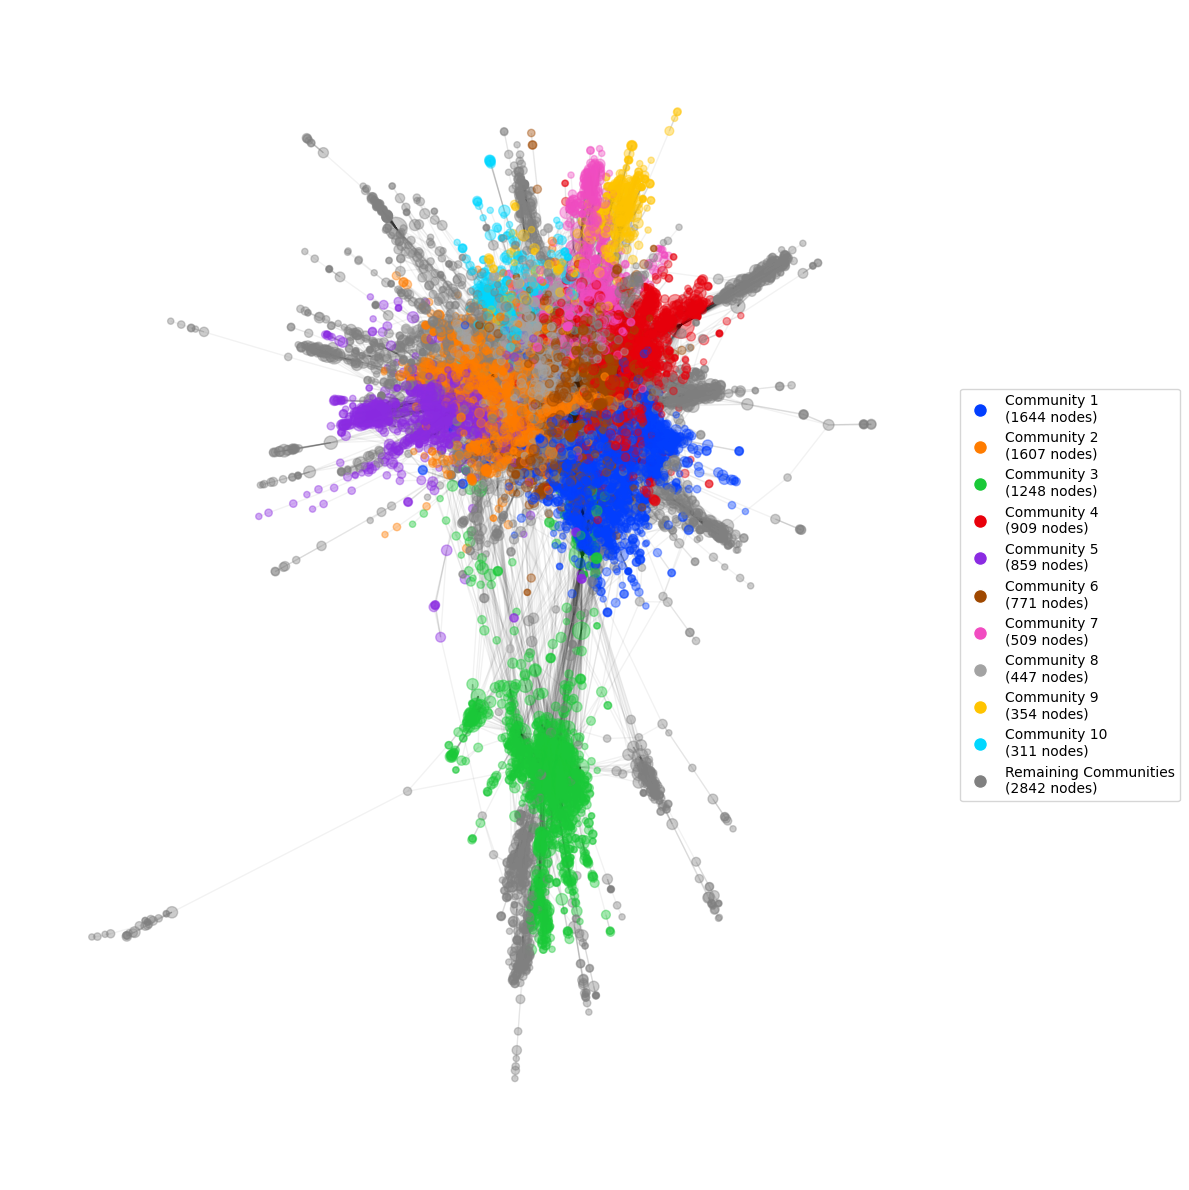

In [45]:
# Get degrees for node sizing
degrees = dict(G_cln_undirected.degree())

# Calculate node sizes (logarithmic scaling)
node_sizes = {node: np.sqrt(100*deg + 1) * 2 for node, deg in degrees.items()}

# Generate color palette for top 10 communities
n_colors = 10
# palette = sns.color_palette("husl", n_colors)
# color_dict = {i: plt.colormaps['hsv'](palette[i]) for i in range(n_colors)}
# palette = sns.color_palette("husl", n_colors)
# palette = sns.color_palette("rainbow", n_colors)
# palette = sns.color_palette("Spectral", n_colors)
# palette = sns.color_palette("deep", n_colors)
palette = sns.color_palette("bright", n_colors)
# palette = plt.cm.tab20(np.linspace(0, 1, n_colors))

# Convert palette colors to RGB format
color_dict = {i+1: rgb2hex(palette[i]) for i in range(n_colors)}  # Now keys are 1-10 instead of 0-9

# Default color for smaller communities
default_color = "#808080"  # grey

# Create reverse mapping of nodes to communities
node_to_community = {}
for comm_id, nodes in community_groups.items():
    for node in nodes:
        node_to_community[node] = comm_id

# Assign colors to nodes
node_colors = []
for node in G_cln_undirected.nodes():
    comm_id = node_to_community[node]
    # Now we can directly use comm_id since color_dict is 1-based
    node_colors.append(color_dict[comm_id] if comm_id <= n_colors else default_color)


# Draw the network
print("Drawing network...")
plt.figure(figsize=(12, 12))

# Draw edges (with alpha for better visibility)
nx.draw_networkx_edges(G_cln_undirected, pos, alpha=0.05, edge_color='black')

# Draw nodes
nx.draw_networkx_nodes(G_cln_undirected, pos,
                        node_size=[node_sizes[node] for node in G_cln_undirected.nodes()],
                        node_color=node_colors,
                        alpha=0.4)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color_dict[i], 
                            label=f'Community {i}\n({len(community_groups[i])} nodes)',
                            markersize=10)
                  for i in range(1, n_colors + 1)]  # Note the range starts at 1

# Add legend element for other communities
if len(community_groups) > 10:
    other_nodes = sum(len(community_groups[i]) for i in range(10, len(community_groups)))
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                    markerfacecolor=default_color,
                                    label=f'Remaining Communities\n({other_nodes} nodes)',
                                    markersize=10))

plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('off')
plt.tight_layout()
plt.show()

This marks the end of finished analysis, from this point on all remaining code is either unfinished avenues of analysis I wanted to further explore, or simply formatting tools.

---
# Unfinished Avenues of Analysis & Other
---

Code to convert split megatable into subtables and automatically convert to LaTeX formatting.

In [46]:
import re

# Convert DataFrame to LaTeX with specified columns
inspect_columns = df_community.columns[:6]
# inspect_rows = rows_affiliations_nlp_properties
inspect_rows = ['Size', 'Internal Density', 'Conductance', 'Average Clustering']

latex_code = df_community.loc[inspect_rows, inspect_columns].to_latex(index=True, column_format='|l'+'|l|'*len(inspect_columns))

# First, let's standardize our line breaks and escape characters
latex_code = latex_code.replace('<br>', '\\')  # Double backslash for LaTeX line breaks
latex_code = latex_code.replace('%', '\%')

# Now we'll add horizontal lines by modifying how rows are joined
lines = latex_code.split('\n')
processed_lines = []

for line in lines:
    # Skip lines that don't contain cells
    if '&' not in line:
        processed_lines.append(line)
        continue

    # Split the line into cells, preserving line ending
    if '\\\\' in line:
        cells_part, ending = line.rsplit('\\\\', 1)
        cells = cells_part.split('&')
        has_ending = True
    else:
        cells = line.split('&')
        has_ending = False
        ending = ''

    # Process each cell
    processed_cells = []
    for i, cell in enumerate(cells):
        cell = cell.strip()
        line_break_count = cell.count('\\\\')
        
        if line_break_count >= 4:
            processed_cells.append(f' \\makecell[l]{{{cell}}}')
        else:
            processed_cells.append(f' {cell}')

    # Rejoin cells and add horizontal line after each row
    processed_line = '&'.join(processed_cells)
    if has_ending:
        processed_line += '\\\\' + ending + '\n\\hline'  # Add \hline for horizontal line
    
    processed_lines.append(processed_line)

# Join all lines
latex_code = '\n'.join(processed_lines)

print(latex_code)

\begin{tabular}{|l|l||l||l||l||l||l|}
\toprule
 & Entire Network& Community 1& Community 2& Community 3& Community 4& Community 5\\
\hline
\midrule
 Size& 11194 (100.0\%)& 1644 (14.7\%)& 1607 (14.4\%)& 1248 (11.1\%)& 909 (8.1\%)& 859 (7.7\%)\\
\hline
 Internal Density& 0.000464& 0.00287 (6.2x)& 0.00250 (5.4x)& 0.00332 (7.1x)& 0.00602 (13.0x)& 0.00504 (10.9x)\\
\hline
 Conductance& NaN& 0.1389& 0.1421& 0.0383& 0.1684& 0.1096\\
\hline
 Average Clustering& 0.4857& 0.4967& 0.4913& 0.4380& 0.5577& 0.4518\\
\hline
\bottomrule
\end{tabular}



Attempt to create a visualization of a hierachical "relationship-tree", similar to how you would portray a family tree. This tree would include both family, master/apprentice and creator/droid relationships in a top-down hierarchy. It was not finished due to time constraints, as calculating the tree position levels requires a specialized, custom built algorithm. The problem is that, since the tree is incomplete, multiple root nodes can exist at each level (e.g. a character without parents is not necessarily the oldest ancestor of all other characters), moving the problem beyond simply finding the "one root" to anchor the hierachy levels from.

In [51]:
# "species", "families", "parents", "partners", "siblings", "children", "masters", "apprentices", "creator"
G_rel = nx.DiGraph()

# Relationship types and their corresponding edge attributes
relationships = {
    'parent': ('parents', 'children'),
    'sibling': ('siblings', 'siblings'),
    'partner': ('partners', 'partners'),
}


for node, data in G_cln.nodes(data=True):
    # Handle each relationship type
    for rel_type, (attr1, attr2) in relationships.items():

        if attr1 in data and data[attr1]:
            # Add edges for the first attribute
            for related in data[attr1]:
                if related in G_cln:
                    # print(attr1, node, related)
                    if attr1 in ['parents']:
                        G_rel.add_edge(related, node, relationship=rel_type)
                    elif attr1 in ['siblings', 'partners']:
                        G_rel.add_edge(node, related, relationship=rel_type)
                        G_rel.add_edge(related, node, relationship=rel_type)
        
        # Handle reciprocal relationships if attr2 exists
        if attr2 and attr2 in data and data[attr2]:
            for related in data[attr2]:
                if related in G_rel:
                    if attr2 in ['children']:
                        G_rel.add_edge(node, related, relationship=rel_type)
                    elif attr2 in ['siblings', 'partners']:
                        G_rel.add_edge(related, node, relationship=rel_type)
                        G_rel.add_edge(node, related, relationship=rel_type)
    
    """
    # Handle family membership separately as it might need special processing
    if 'families' in data and data['families']:
        for family in data['families']:
            # Add family as a node with special attribute
            G_rel.add_node(family, type='family')
            G_rel.add_edge(node, family, relationship='family_member')
    """


# print(len(G_rel.nodes()), len(G_rel.edges()), G_rel.nodes())

In [48]:
# Find all 
# Characters who share edges in both directions are siblings or partners, and should be plotted close to each other on the same level
# Characters who have an edge towards one character (but not the other way around) in one direction are parents, masters or creators, and should be plotted on a level above their children or apprentrices
# Siblings should be closer to each other, and partners should be closer to each other

# Siblings should be on the same level and close to each other.
# Partners should be on their own separate level slightly below or above their partners level (but at the same level as their siblings) 
# Parents should be on a level far above their children (but at the same level as their siblings)


# Start by choosing a random node, and assign them a level score 1. Iteratively find all their siblings and partners, assign them the same level score, before . Remember list of all characters on each level.
# Find all their siblings and partners, assign them
# Calculate level score. Assign for first node as 1, and assign same score to all their siblings and partners. Remember list of all characters on each level.
# Find all parents and assign them a level score of 2. Assign same level score to all their siblings and partners. Remember list of all characters on each level.


In [49]:
from queue import Queue

node = 'Anakin Skywalker'


# Start of the process
level_dict = {}
visited_nodes = set()

# Level specific
level_equal = set()
level_above = set()
level_below = set()

# Define starting node for level
current_node = 'Anakin Skywalker'
current_level = 0

# Initialize level dictionary with the current node or update the current node
level_dict[current_level] = set()
level_dict[current_level + 1] = set() # Initialize the level above
level_dict[current_level - 1] = set() # Initialize the level below

level_dict[current_level].add(current_node)

# Initialize level queue
q_level = Queue()
q_level.put(current_node)

# Visit all nodes in current level
while not q_level.empty():
    current_node = q_level.get() # Remove the node from the queue
    visited_nodes.add(current_node) # Add the node to the visited nodes
    
    # print(current_node)
    # print(G_cln.nodes[current_node]['siblings'])
    # print(G_cln.nodes[current_node]['partners'])
    # print(G_cln.nodes[current_node]['parents'])
    # print(G_cln.nodes[current_node]['children'])

    siblings = [equal_node for equal_node in G_cln.nodes[current_node]['siblings']]
    partners = [equal_node for equal_node in G_cln.nodes[current_node]['partners']]
    parents = [above_node for above_node in G_cln.nodes[current_node]['parents']]
    children = [below_node for below_node in G_cln.nodes[current_node]['children']]

    for sibling in siblings:
        if sibling not in visited_nodes:
            level_dict[current_level].add(sibling)
    for partner in partners:
        if partner not in visited_nodes:
            level_dict[current_level].add(partner)
    for parent in parents:
        if parent not in visited_nodes:
            level_dict[current_level+1].add(parent)
    for child in children:
        if child not in visited_nodes:
            level_dict[current_level-1].add(child)
    
    for node in [equal_node for equal_node in level_dict[current_level] if equal_node not in visited_nodes]: # Add all equal level nodes to the queue if they have not been visited
        q_level.put(node)

# When done with current level, should move one above until done, then go up again. When none unvisited levels exist above, go below until find level with unvisited nodes

level_dict

{0: {'Anakin Skywalker',
  'Beru Whitesun Lars',
  'Owen Lars',
  'Padmé Amidala',
  'Palo Jemabie',
  'Rush Clovis',
  'Sola Naberrie'},
 1: {'Aika Lars',
  'Cliegg Lars',
  'Jobal Naberrie',
  "Rush Clovis's father",
  'Ruwee Naberrie',
  'Shmi Skywalker Lars',
  'Unidentified Muun banker'},
 -1: {'Leia Skywalker Organa Solo',
  'Luke Skywalker',
  'Pooja Naberrie',
  'Ryoo Naberrie'}}